In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import gdown

## Loading and cleaning

In [12]:
# Loading data from GDrive.

# Data with BDL merged,
file_id = "1SYvX9OHdWpuDWgYSWIfnZHJy2DL0p5lN"
url = f"https://drive.google.com/uc?id={file_id}"
file_extension = "downloaded_file.csv"
gdown.download(url, file_extension, quiet=False)
df = pd.read_csv(file_extension, sep=",")

Downloading...
From (original): https://drive.google.com/uc?id=1SYvX9OHdWpuDWgYSWIfnZHJy2DL0p5lN
From (redirected): https://drive.google.com/uc?id=1SYvX9OHdWpuDWgYSWIfnZHJy2DL0p5lN&confirm=t&uuid=e103af49-7599-4262-92cc-8ec98ea6bfdb
To: C:\Users\KW\PycharmProjects\2024-mgr-sluzba-cywilna\Python\Code\downloaded_file.csv
100%|██████████| 254M/254M [00:07<00:00, 33.2MB/s] 


In [13]:
# Dropping data from 2017: too few records.
df = df[df['year'] > 2017]

# Dropping advertised_institution (too many nulls).
df.drop(['advertised_institution'], axis=1, inplace=True)

In [4]:
# Changing "," to "." in numerical variables.
comma_cols_to_replace = {
    'mediana_wieku': 'bdl_age_median',
    'wydatki_powiat': 'bdl_district_expenses',
    'wynagrodzenia': 'bdl_average_salary'
}

# Replace commas with dots and convert to float.
for old_col, new_col in comma_cols_to_replace.items():
    try:
        df[new_col] = df[old_col].str.replace(',', '.', regex=False).astype(float)
    except AttributeError:
        df[new_col] = df[old_col]
        continue

df.drop(columns=comma_cols_to_replace.keys(), inplace=True)

In [5]:
# Other columns to rename.
col_names_to_replace = {
    'cena_mieszkan': 'bdl_avg_house_pricing',
    'saldo_migracji': 'bdl_migration_coefficient',
    'wsp_feminizacji': 'bdl_feminization_coefficient'
}

for old_col, new_col in col_names_to_replace.items():
    df[new_col] = df[old_col].astype(float)
    df.drop([old_col], axis=1, inplace=True)

In [6]:
df['work_time_over_1'] = (df['work_time'] > 1).astype(int)
df['full_time_job'] = (df['work_time'] == 1).astype(int)
df['work_time_below_1'] = (df['work_time'] < 1).astype(int)
df.drop(['work_time'], axis=1, inplace=True)

## Imputation

In [7]:
# Imputing values for salary_for_position, since this variable has relatively low variance and is potentially of greater importance.
# However, imputing at institution-level won't solve the problem completely,
# since for some institutions, years or districts there was no data about salary at all.
# What is more, there was no salary data for średni szczebel zarządzania position category in the original data.
# Fortunately, that information was available here:
# https://dane.gov.pl/pl/dataset/1579/resource/56259,przecietne-wynagrodzenie-cakowite-wedug-grup-stanowisk-2023-r/table?page=1&per_page=20&q=&sort=
# For this reason, 6 imputations are needed (the sequence matters).

df_for_imputation_institution_level = df[df['salary_for_position'].notnull()]
df_for_imputation_district_level = df[df['salary_for_position'].notnull()]
df_for_imputation_voivodeship_level = df[df['salary_for_position'].notnull()]
df_for_imputation_year_level = df[df['salary_for_position'].notnull()]
df_for_imputation_category_level = df[df['salary_for_position'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_year'})
)

df_for_imputation_category_level = (
    df_for_imputation_category_level
    .groupby(['position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_category'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year', 'position_category'], how='left')
df = df.merge(df_for_imputation_category_level, on=['position_category'], how='left')

df['salary_for_position'] = df['salary_for_position'].fillna(df['median_institution'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_district'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_voivodeship'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_year'])

df = df.drop(columns=['median_institution', 'median_category', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

# Assigning mean salaries for sredni szczebel zarzadzania manually (from the mentioned link):
mean_sredni_szczebel_2023 = 13160
mean_sredni_szczebel_2022 = 11322
mean_sredni_szczebel_2021 = 10579
mean_sredni_szczebel_2020 = 12633
mean_sredni_szczebel_2019 = 11693
mean_sredni_szczebel_2018 = 11088

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2023),
    'salary_for_position'
] = mean_sredni_szczebel_2023

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2022),
    'salary_for_position'
] = mean_sredni_szczebel_2022

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2021),
    'salary_for_position'
] = mean_sredni_szczebel_2021

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2020),
    'salary_for_position'
] = mean_sredni_szczebel_2020

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2019),
    'salary_for_position'
] = mean_sredni_szczebel_2019

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2018),
    'salary_for_position'
] = mean_sredni_szczebel_2018

## Feature engineering

In [8]:
df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)
df['offer_salary_mentioned'] = df['offer_salary'].notna().astype(int)
df.drop(['offer_salary'], axis=1, inplace=True)

C:\Users\KW\AppData\Local\Temp\ipykernel_16668\2997230914.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)


In [9]:
df['len_requirements'] = df['requirements'].str.count("|-|") + 1
df['len_nice_to_have'] = df['nice_to_have'].str.count("|-|") + 1
df['len_responsibilities'] = df['responsibilities'].str.count("|-|") + 1

# null for nice-to-have means no nice-to-have.
df.loc[df['nice_to_have'].isnull(), 'nice_to_have'] = 0

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99333 entries, 0 to 99332
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ad_id                         99333 non-null  int64  
 1   result                        99333 non-null  int64  
 2   job_field                     99333 non-null  object 
 3   position_category             99333 non-null  object 
 4   position                      99333 non-null  object 
 5   education_level               99333 non-null  int64  
 6   vacancies                     99333 non-null  int64  
 7   city                          99333 non-null  object 
 8   institution                   99333 non-null  object 
 9   workplace                     99333 non-null  object 
 10  department                    99333 non-null  object 
 11  institution_address           99333 non-null  object 
 12  responsibilities              99333 non-null  object 
 13  r

## Analyses

##### Correlation

In [ ]:
# Dealing with categorical columns.
df = pd.get_dummies(df, columns=['position_category', 'job_field'], drop_first=True)

In [ ]:
from scipy import stats
# Variable correlation.

# From scipy documentation:
# "Calculates a point biserial correlation coefficient and the associated p-value.
# The point biserial correlation is used to measure the relationship between a binary variable, x, and a continuous variable, y. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply a determinative relationship".

numerical_columns = [
    'work_time',
    'ad_views',
    'applicants',
    'offer_salary_mentioned',
    'salary_for_position',
    'women_percentage',
    'bdl_feminization_coefficient',
    'fluctuation',
    'employment_contract',
    'bdl_avg_house_pricing',
    'bdl_age_median',
    'bdl_migration_coefficient',
    'bdl_district_expenses',
    'bdl_average_salary',
    'vacancies',
    'len_requirements',
    'len_nice_to_have',
    'len_responsibilities'
]

correlation_results = {}
for col in numerical_columns:
    x = df['result']
    y = df[col]
    valid = x.notna() & y.notna()
    r, p = stats.pointbiserialr(x[valid], y[valid])
    correlation_results[col] = {
        'correlation': r,
        'is_statistically_significant': int(p <= 0.05)
    }

correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index')
correlation_df = correlation_df.sort_values(by='is_statistically_significant', ascending=False)

print(correlation_df)

In [ ]:
df[numerical_columns].describe()

##### Bar charts

In [10]:
def plot_ibcs_bar_chart(df: pd.DataFrame, group_col: str):

    group_means = df.groupby(group_col)['result'].mean().reset_index()
    group_means.sort_values(by='result', ascending=False, inplace=True)

    ibcs_palette = ['#000000', '#444444', '#777777', '#AAAAAA', '#DDDDDD']
    sns.set(style='whitegrid')
    
    plt.figure(figsize=(15, 7))
    ax = sns.barplot(
        x=group_col, 
        y='result', 
        data=group_means, 
        palette=ibcs_palette[:len(group_means)],
        edgecolor='black'
    )

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=13, fontweight='bold')

    ax.set_title(f"Mean result by {group_col}", fontsize=14, weight='bold')
    ax.set_ylabel("Mean result", fontsize=12)
    ax.set_xlabel(group_col, fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    sns.despine()
    
    plt.tight_layout()
    plt.show()

C:\Users\KW\AppData\Local\Temp\ipykernel_12812\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


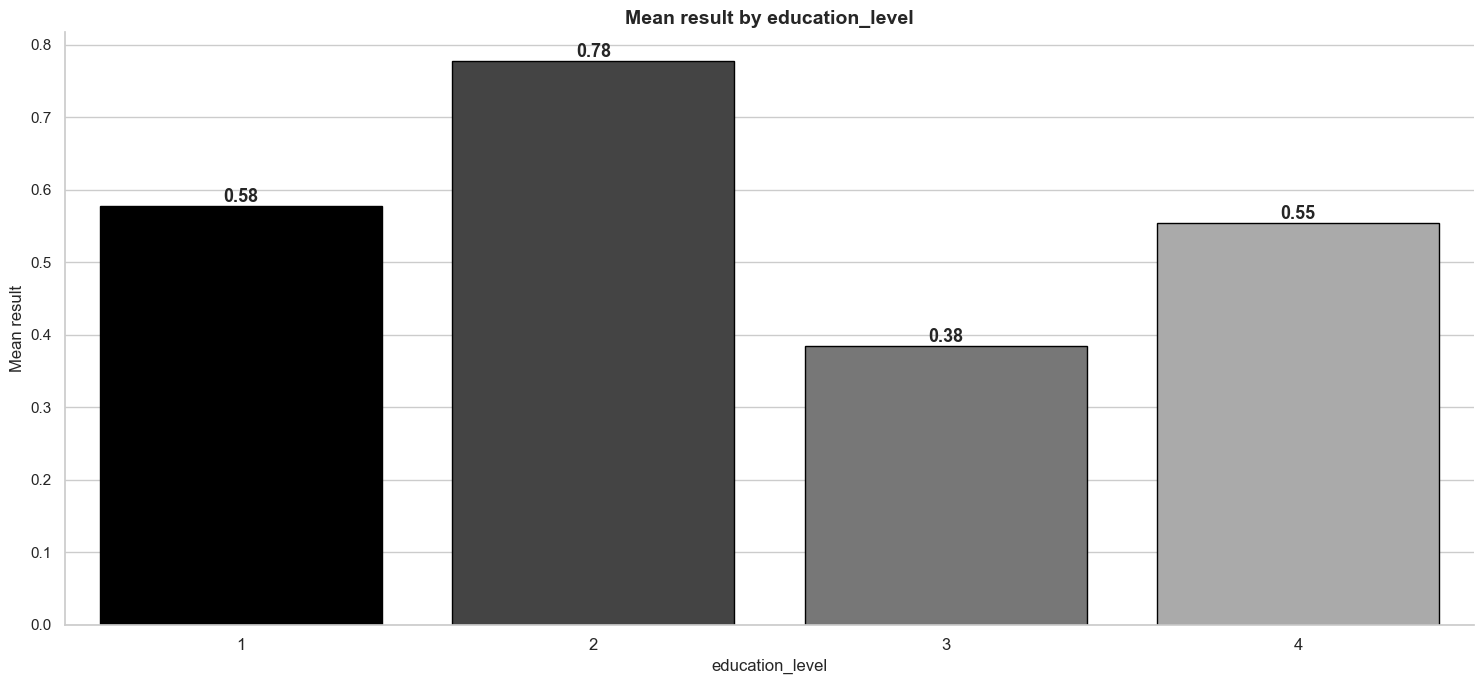

C:\Users\KW\AppData\Local\Temp\ipykernel_12812\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\KW\AppData\Local\Temp\ipykernel_12812\1369376441.py:10: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


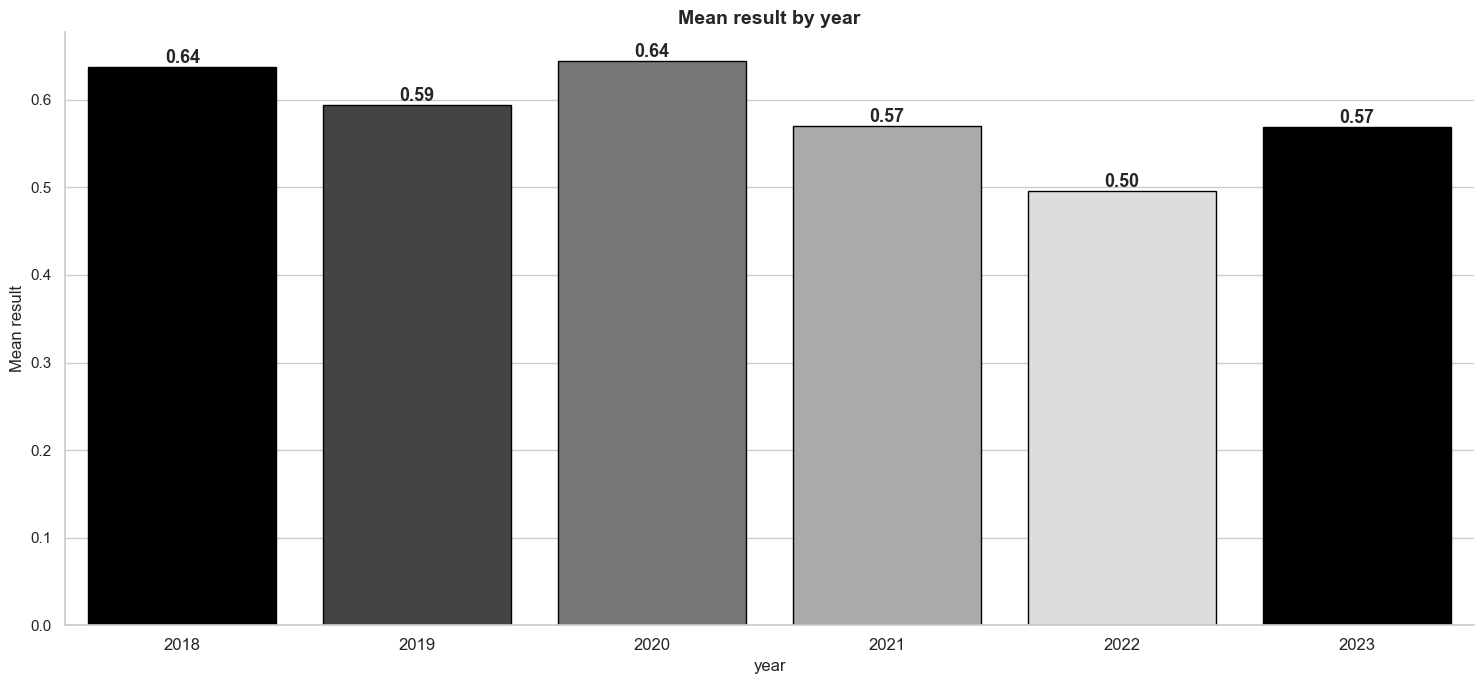

C:\Users\KW\AppData\Local\Temp\ipykernel_12812\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\KW\AppData\Local\Temp\ipykernel_12812\1369376441.py:10: UserWarning: 
The palette list has fewer values (5) than needed (11) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


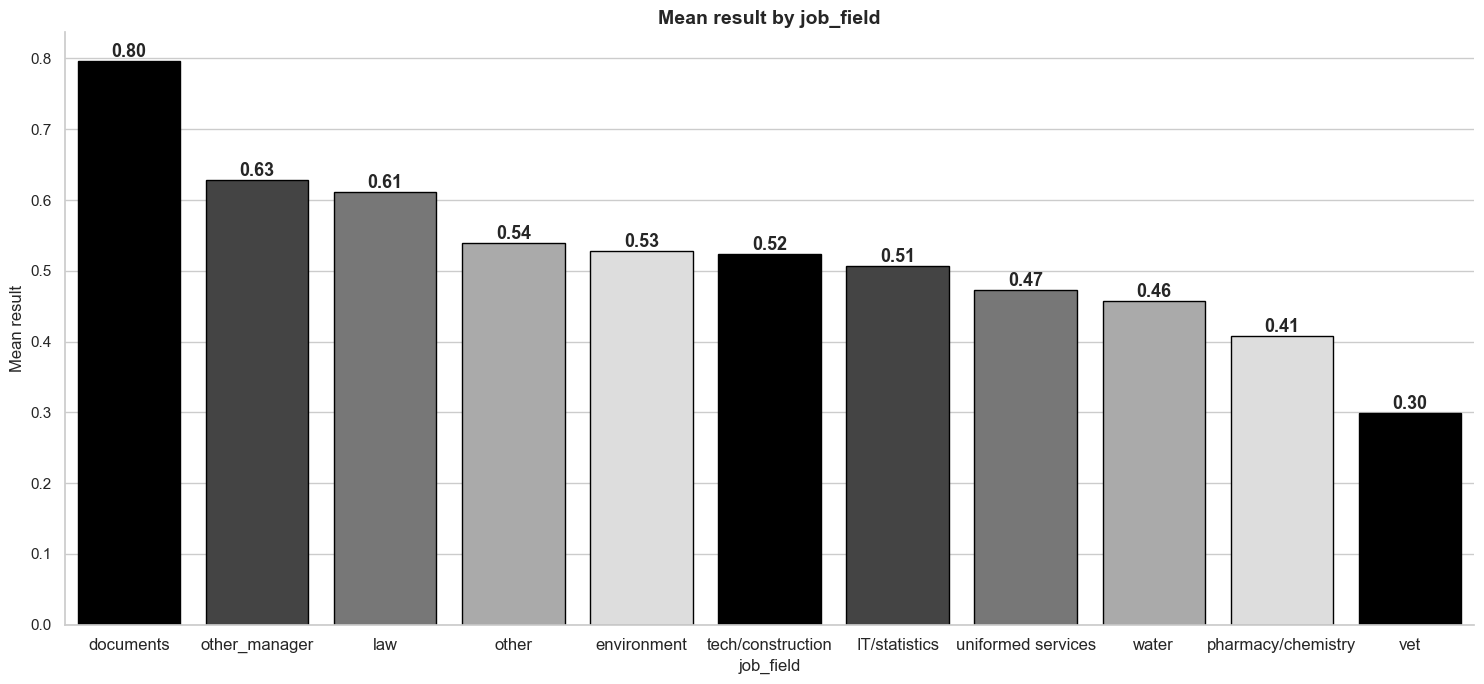

C:\Users\KW\AppData\Local\Temp\ipykernel_12812\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\KW\AppData\Local\Temp\ipykernel_12812\1369376441.py:10: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


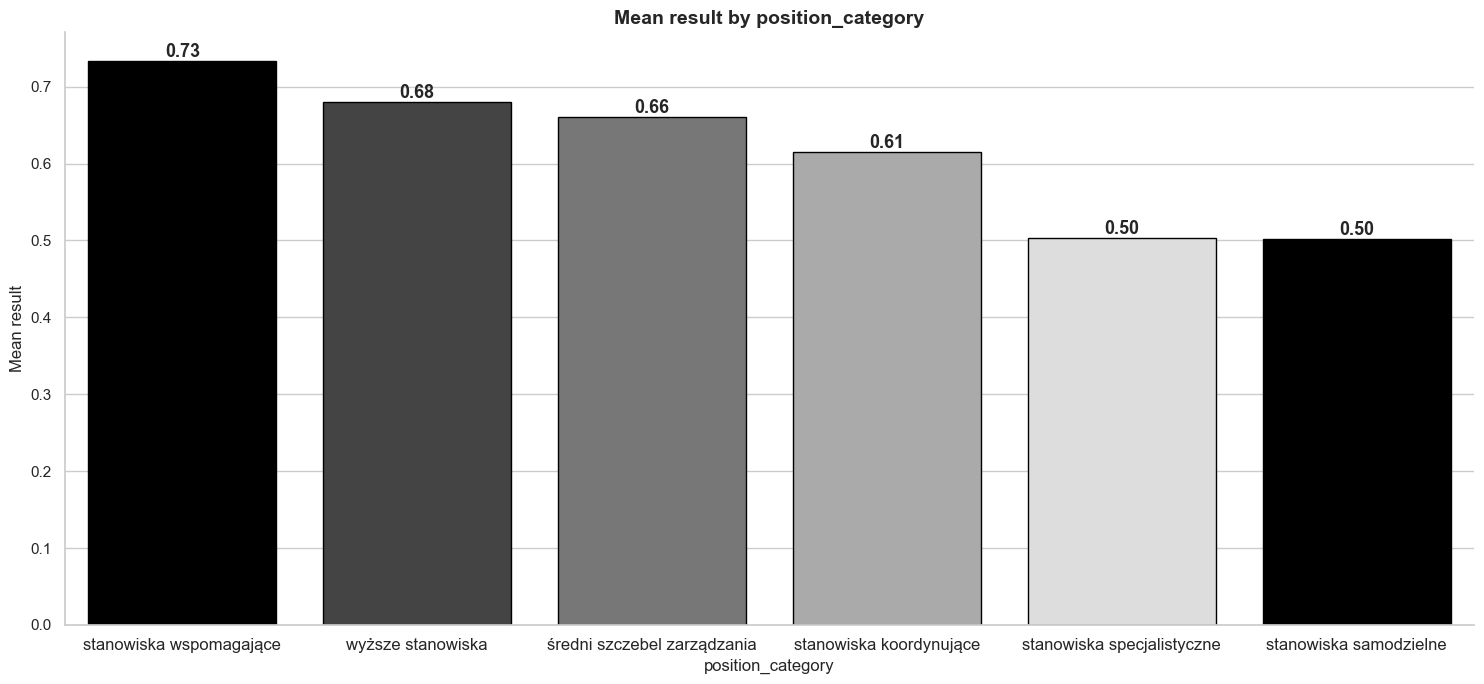

In [11]:
plot_bar_columns = [
    'education_level',
    'year',
    'job_field',
    'position_category'
]

for column in plot_bar_columns:
    plot_ibcs_bar_chart(df, column)

##### Time series

In [ ]:
# Dropping cols unnecessary for statistical analyses.
string_cols_for_temporary_dropping = [
    'ad_id',
    'institution_address',
    'workplace',
    'department',
    'responsibilities',
    'requirements',
    'offer_salary',
    'date_announced',
    'nice_to_have',
    'institution_address',
    'workplace',
    'department',
    'city',
    'position'
]
df_for_charts = df.drop(string_cols_for_temporary_dropping, axis=1)

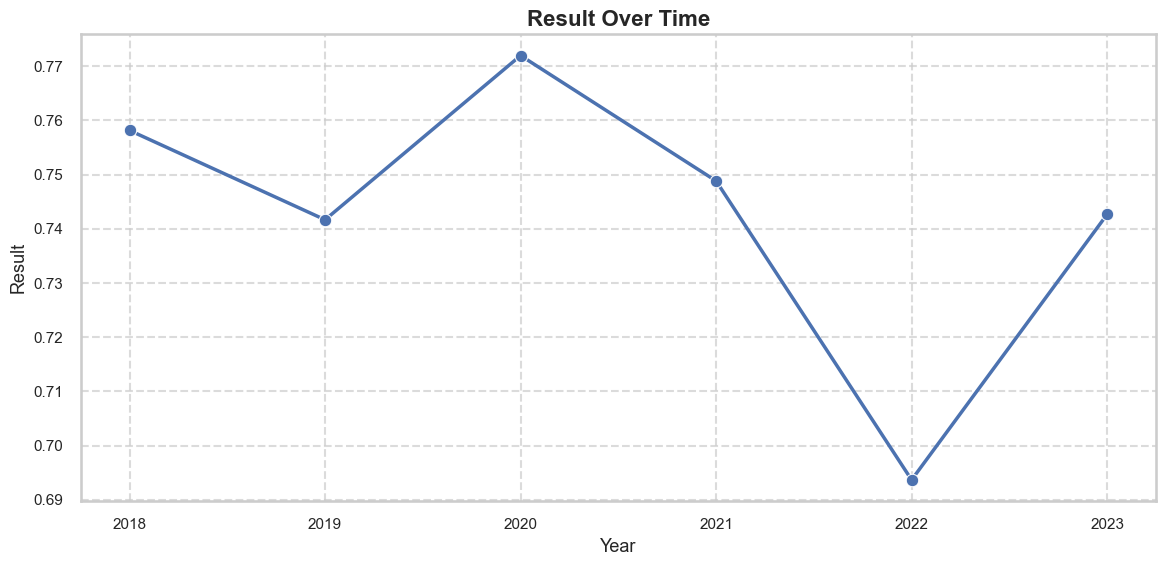

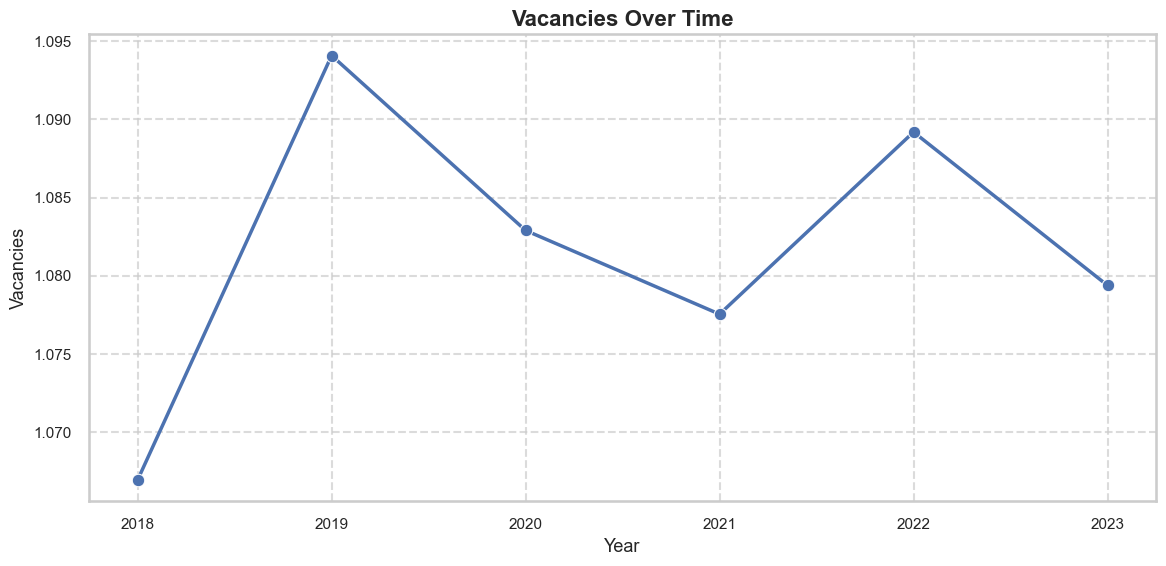

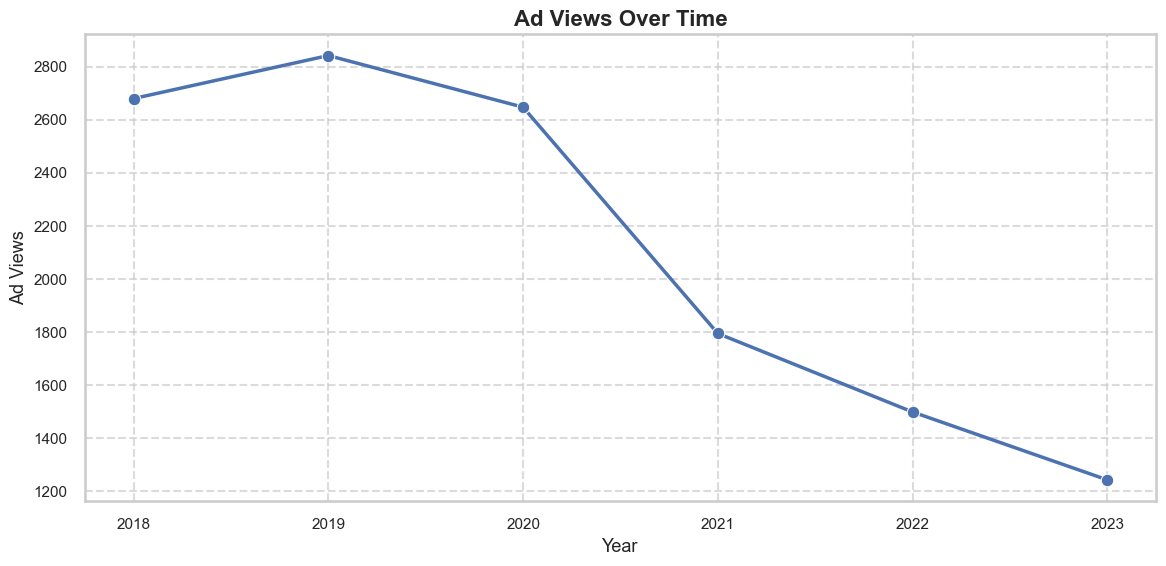

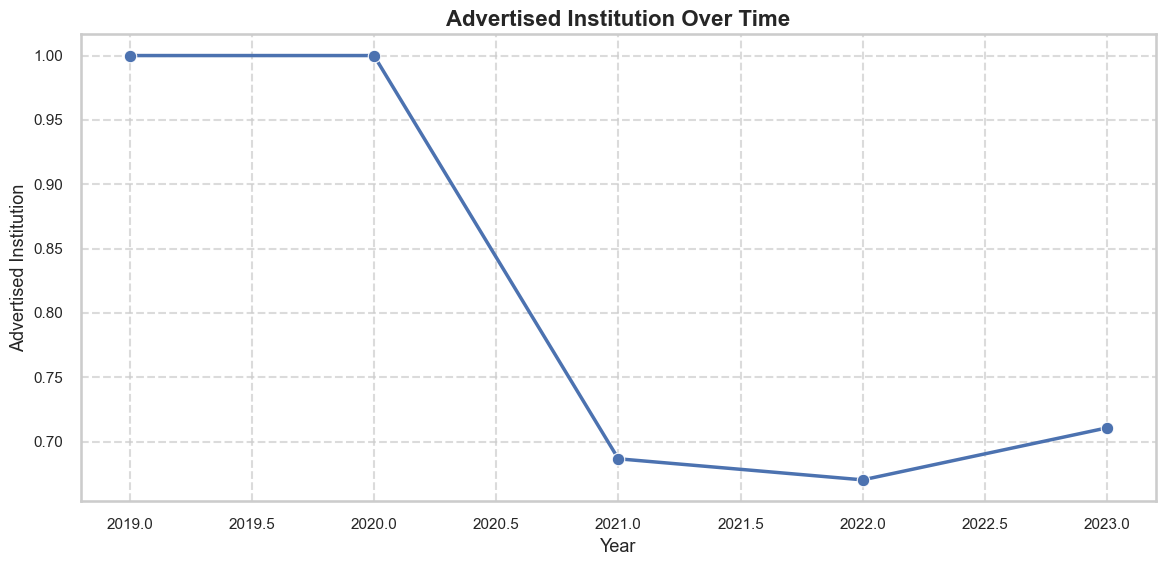

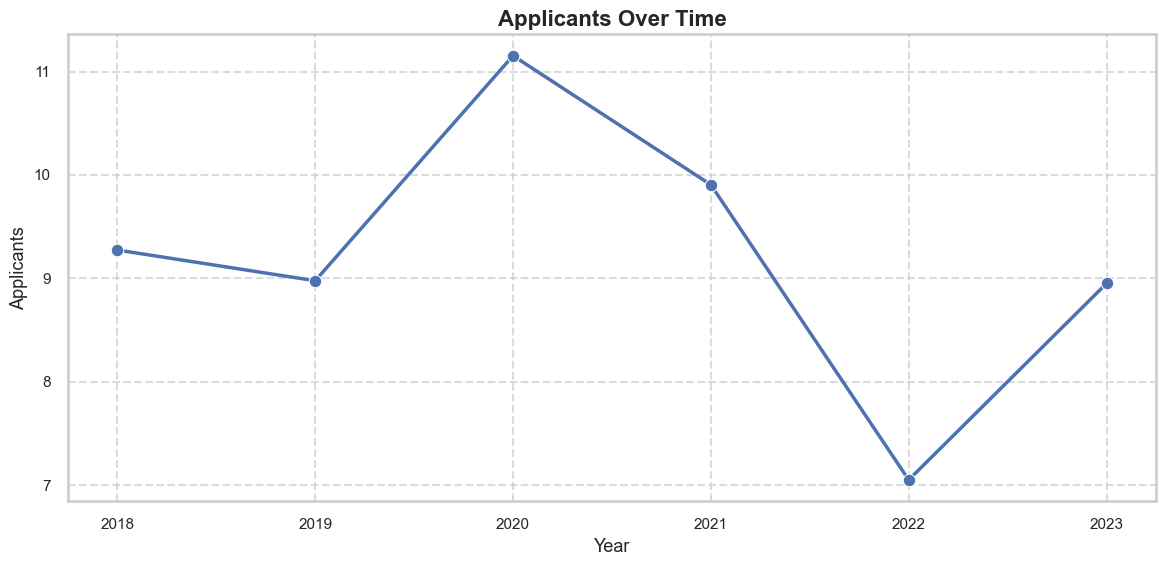

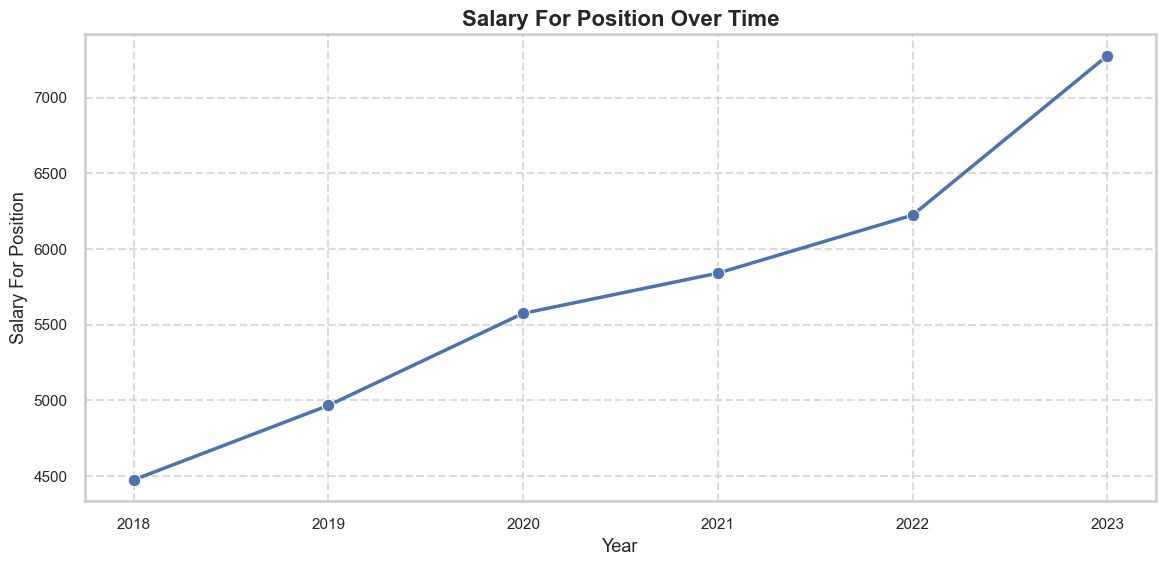

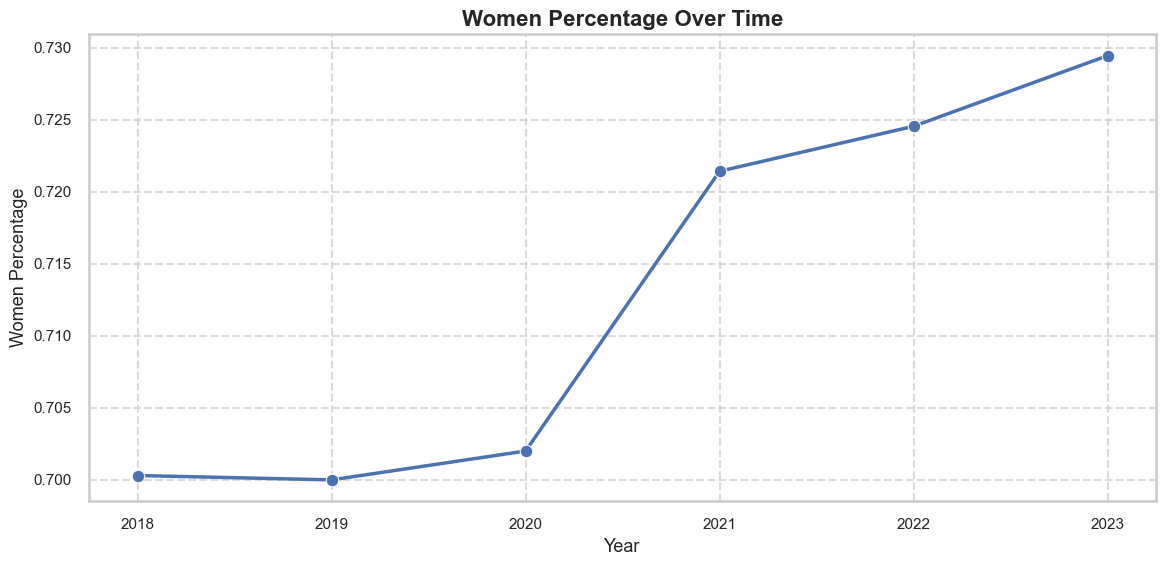

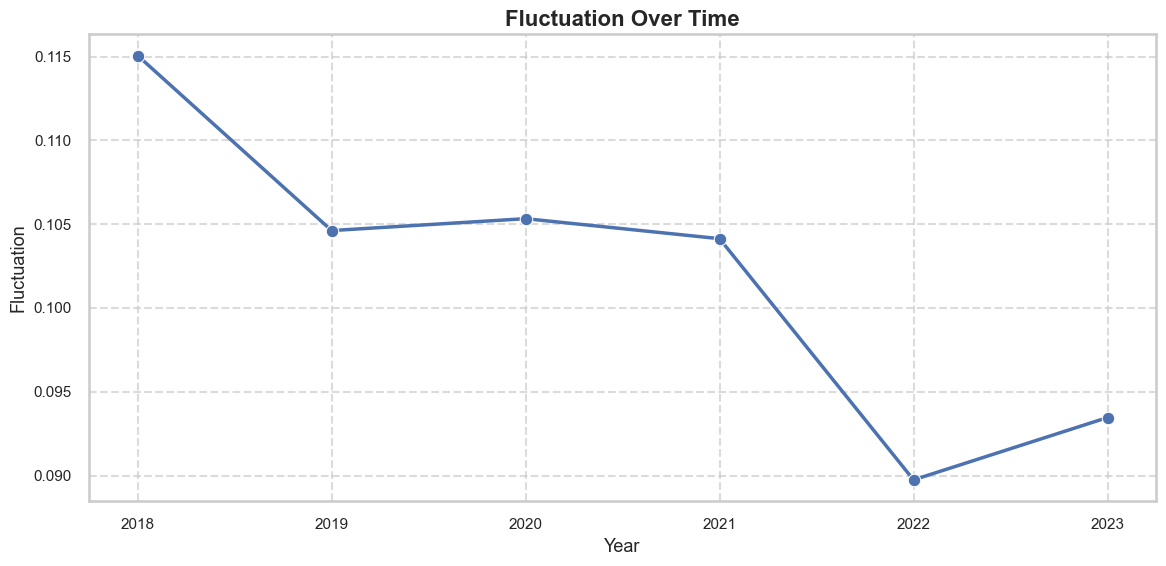

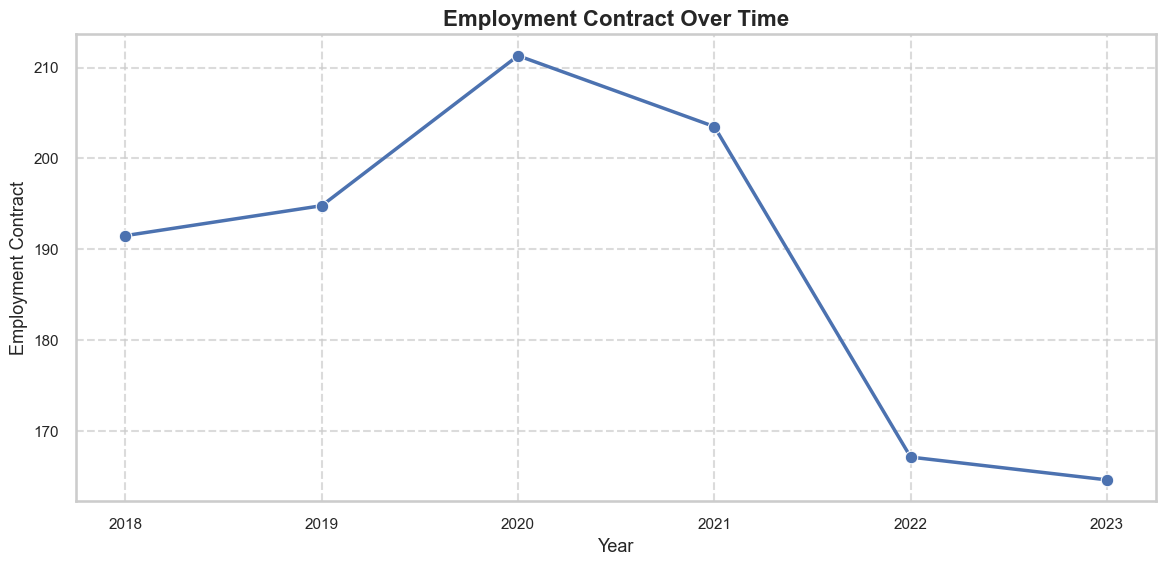

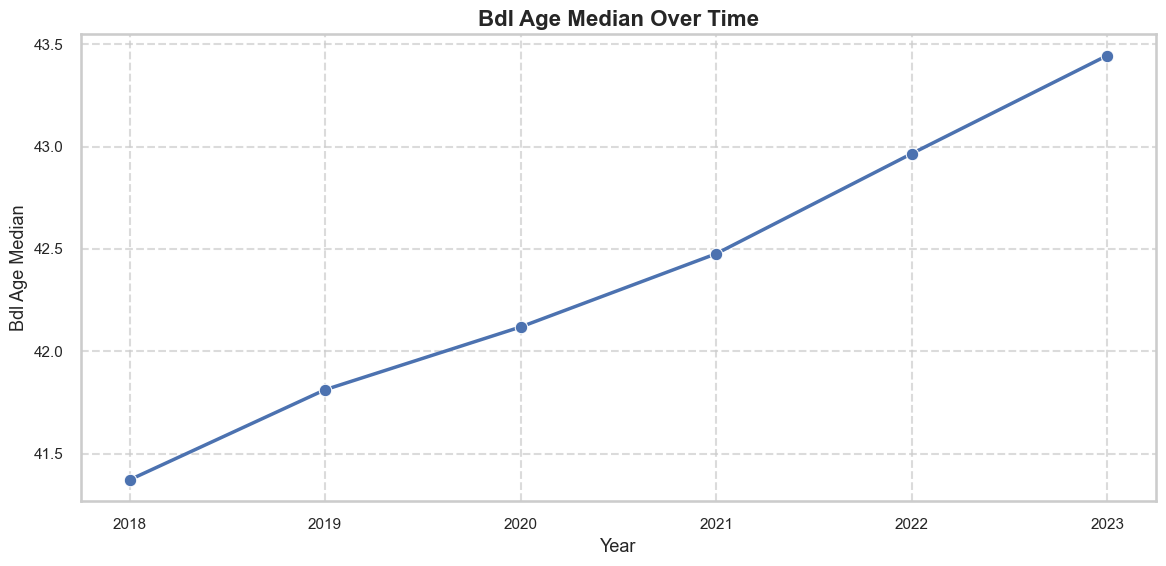

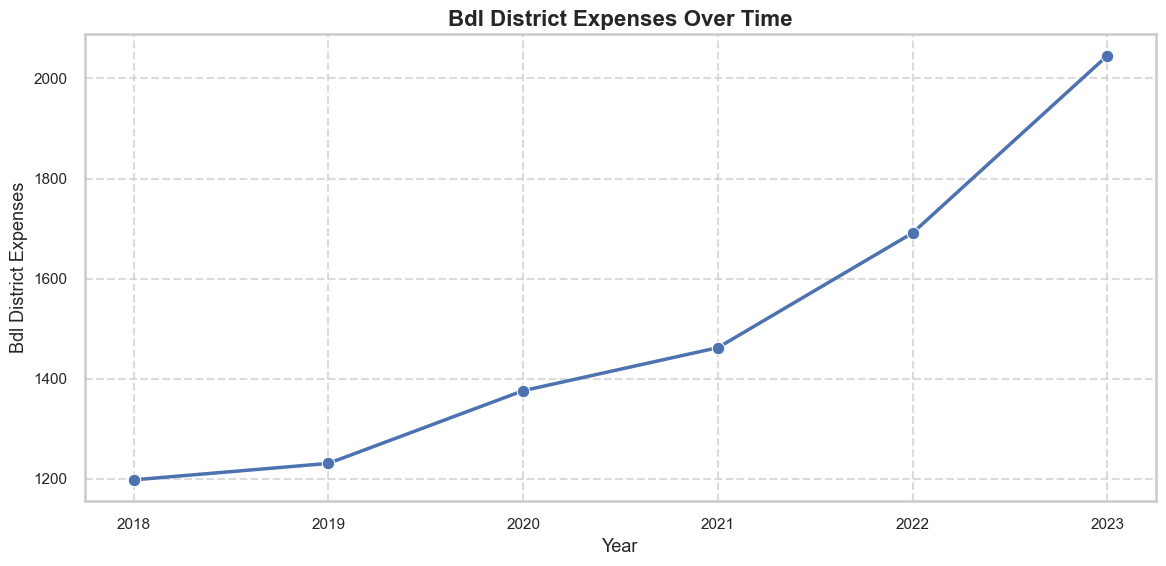

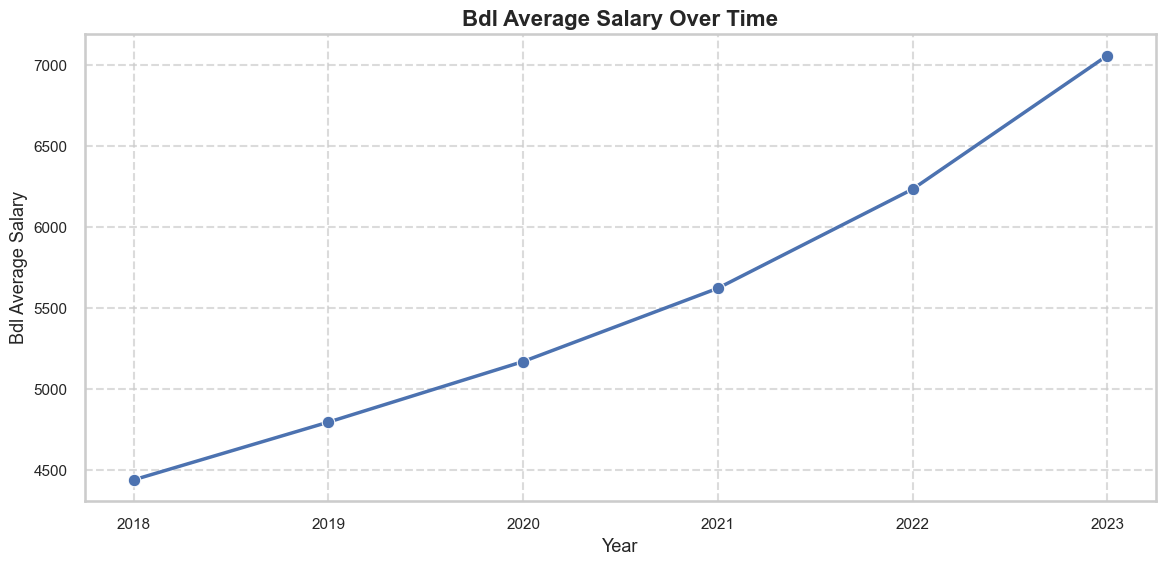

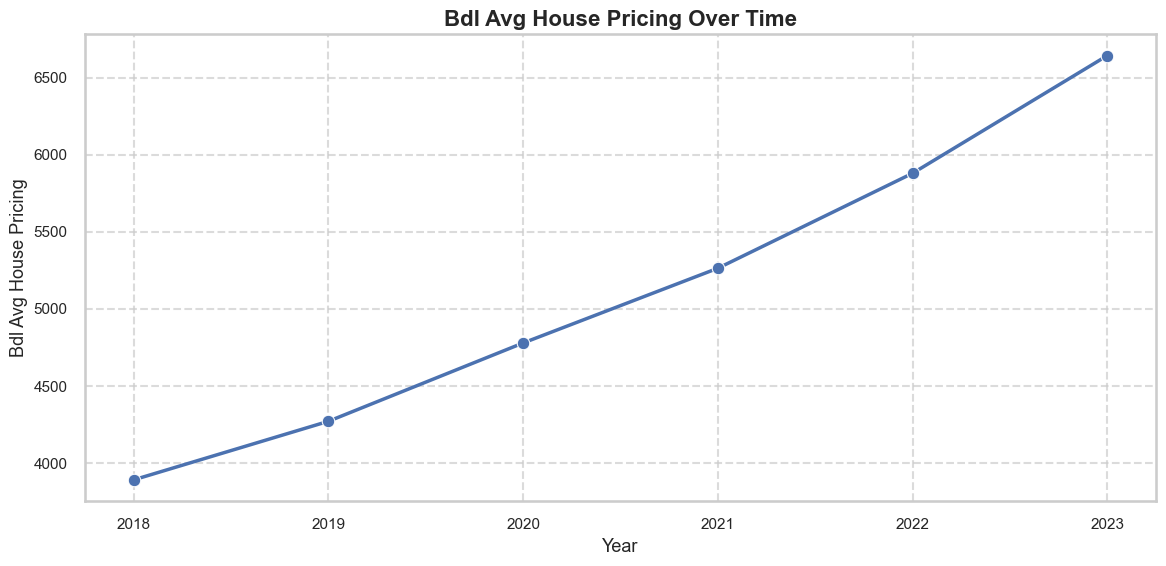

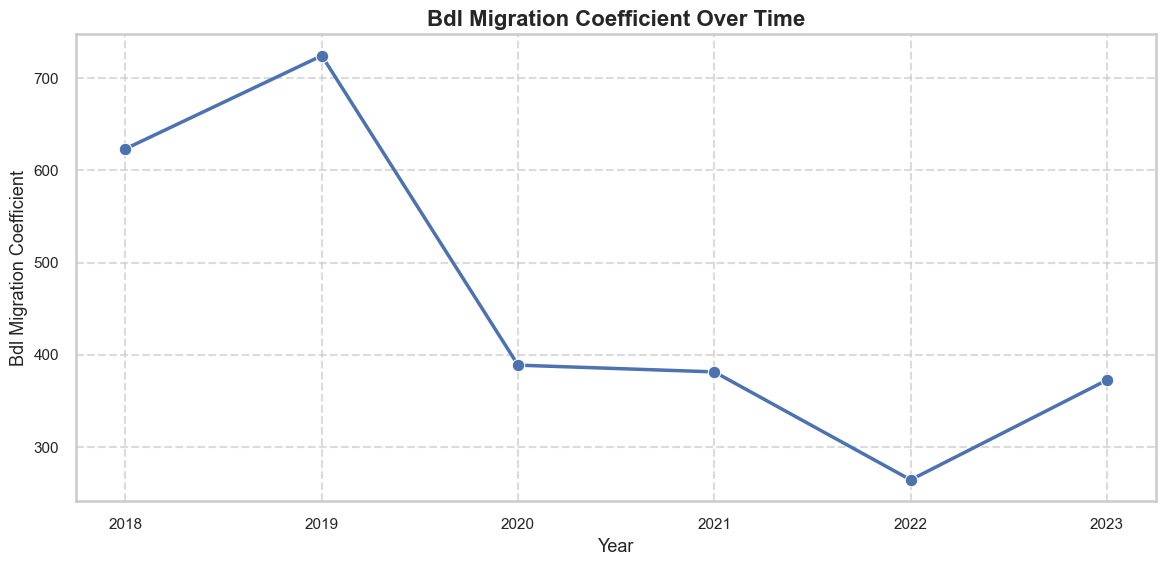

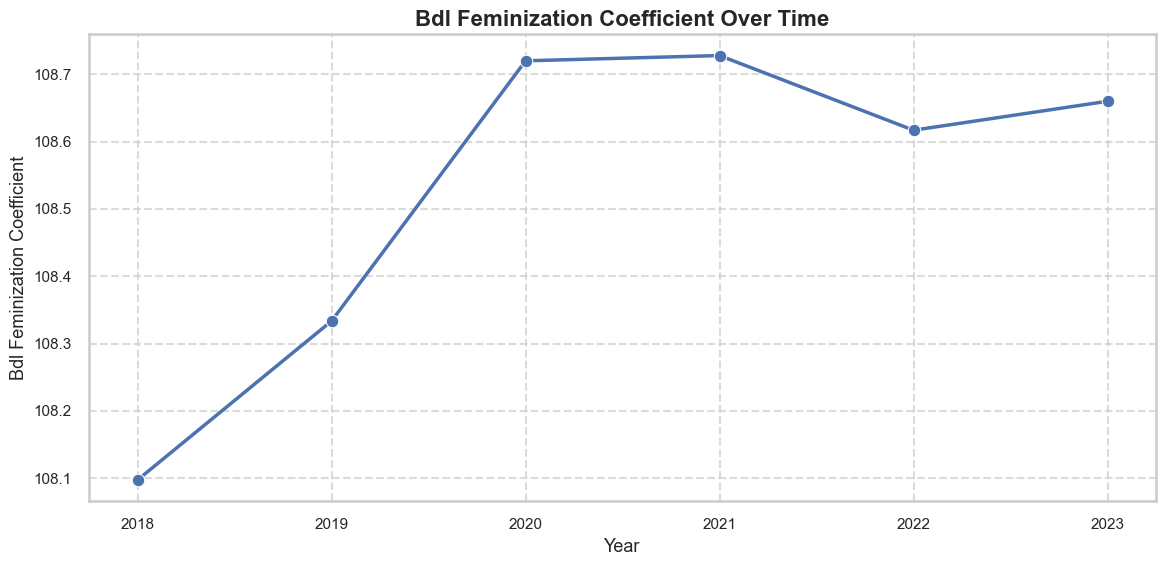

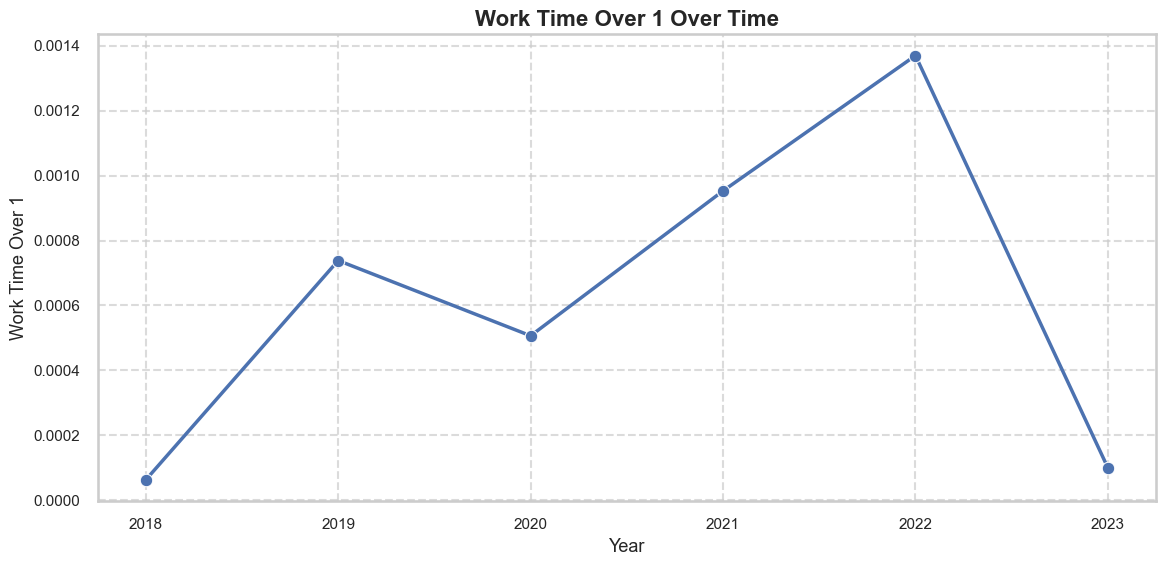

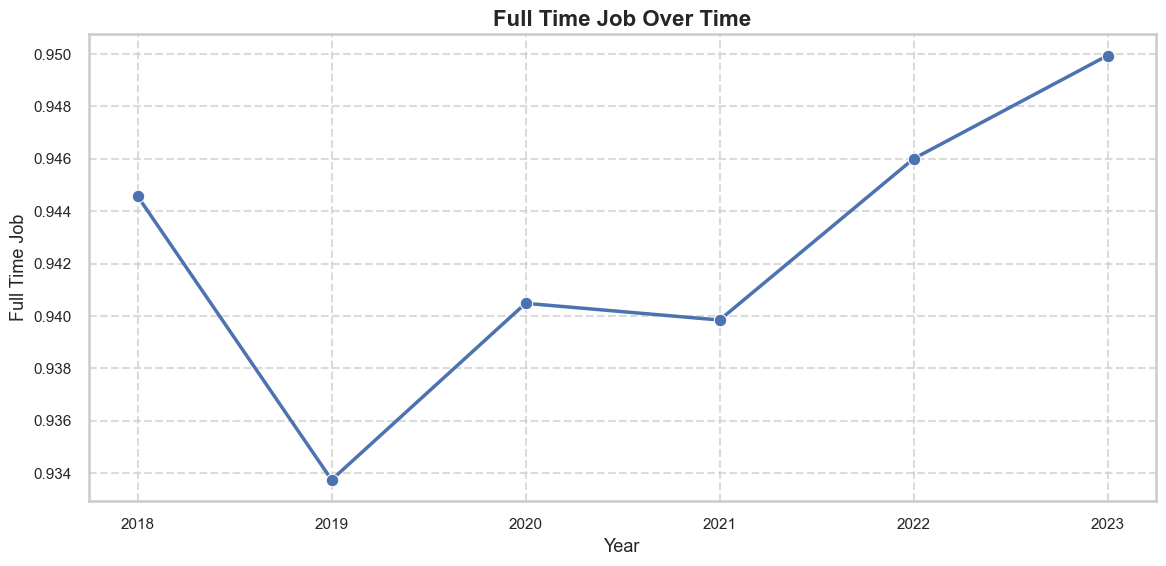

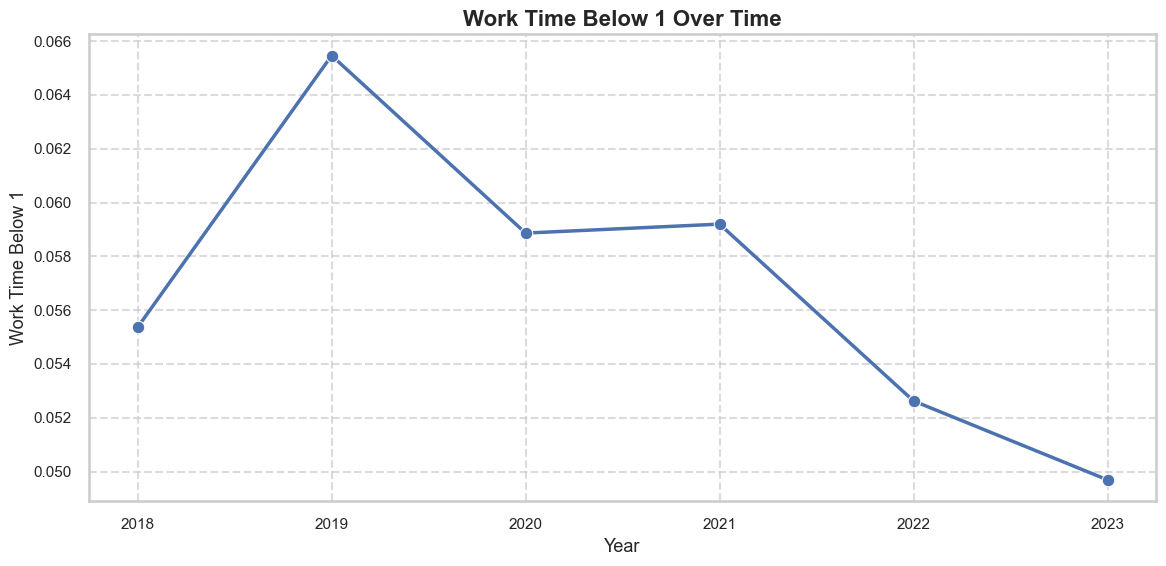

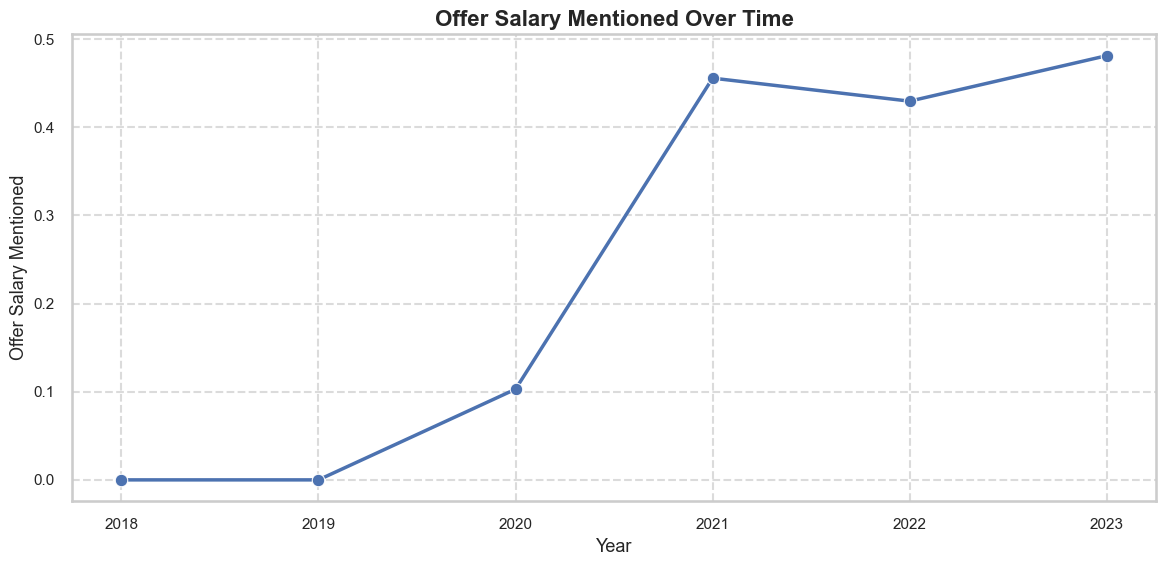

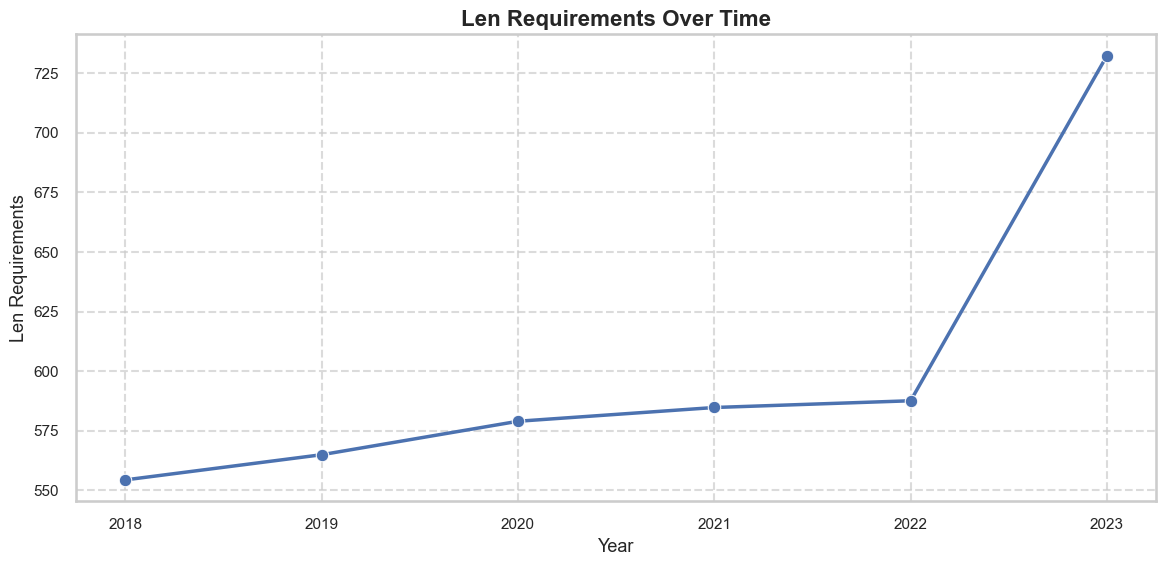

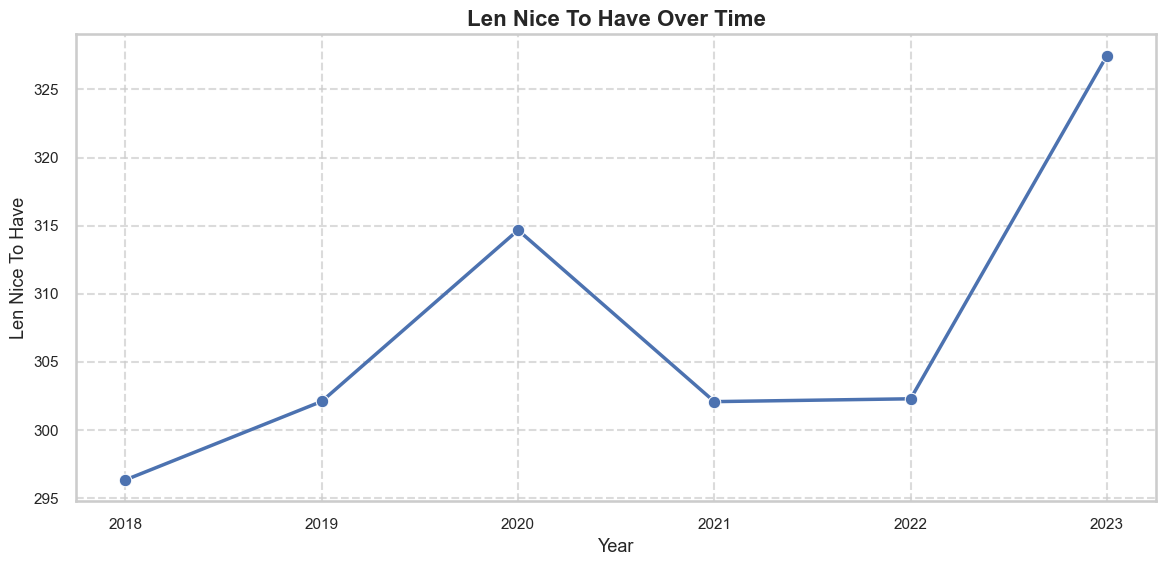

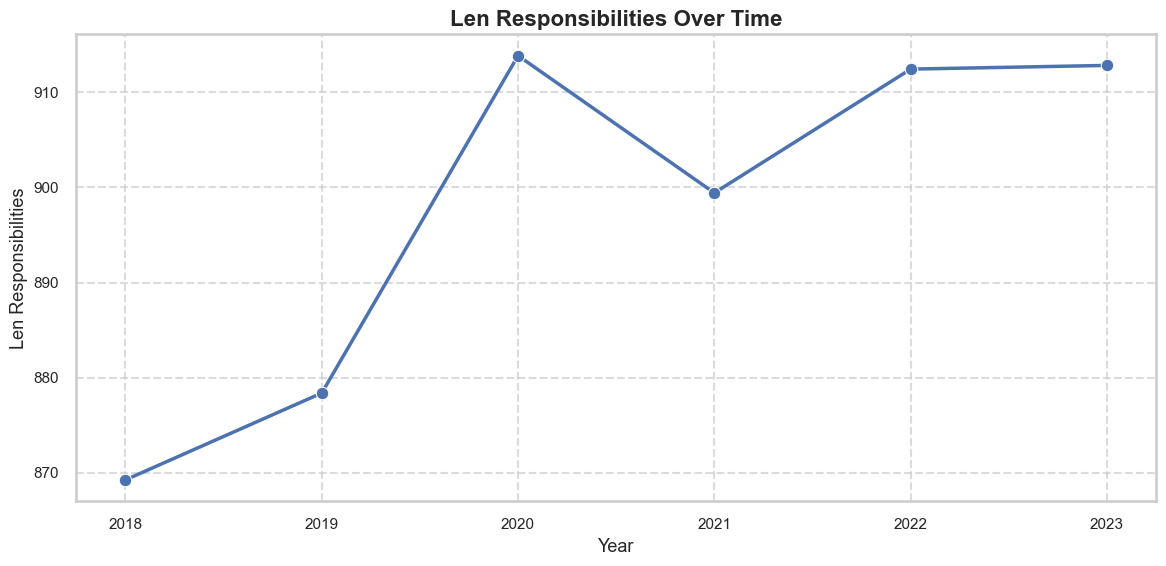

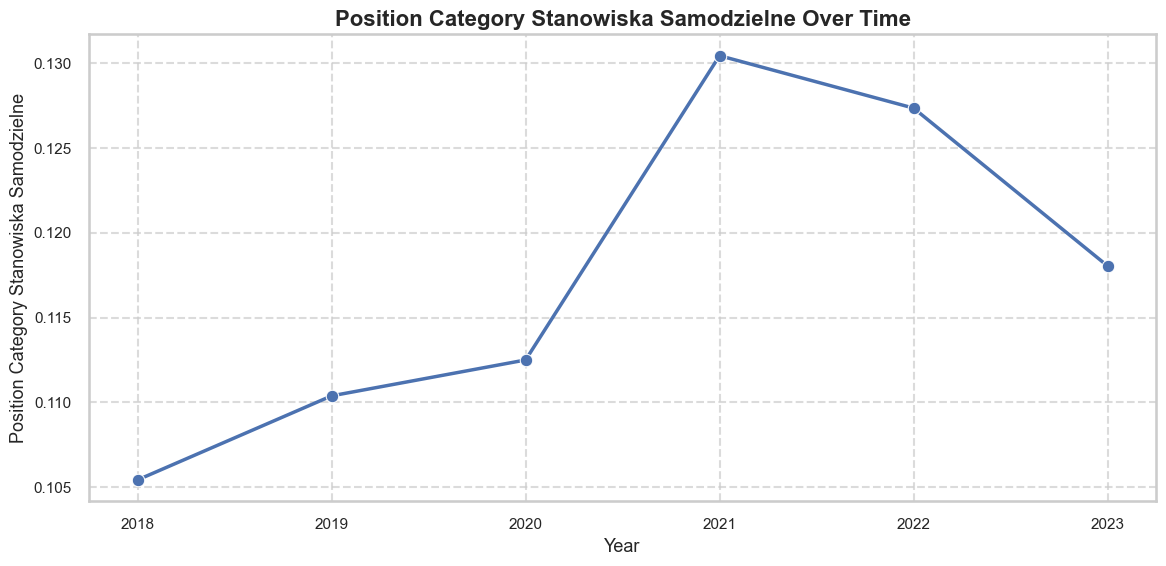

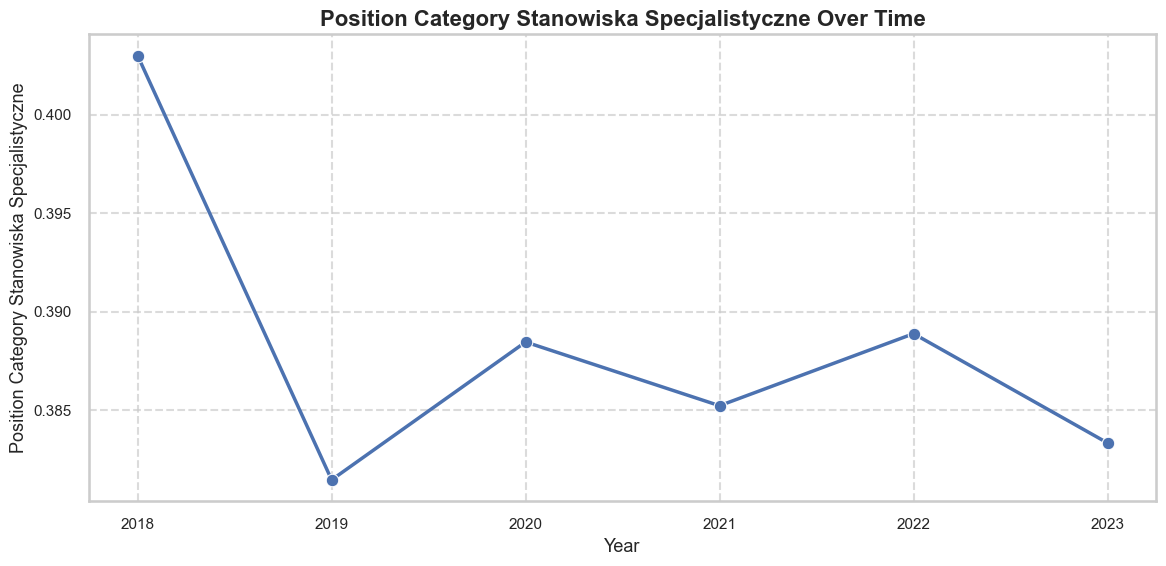

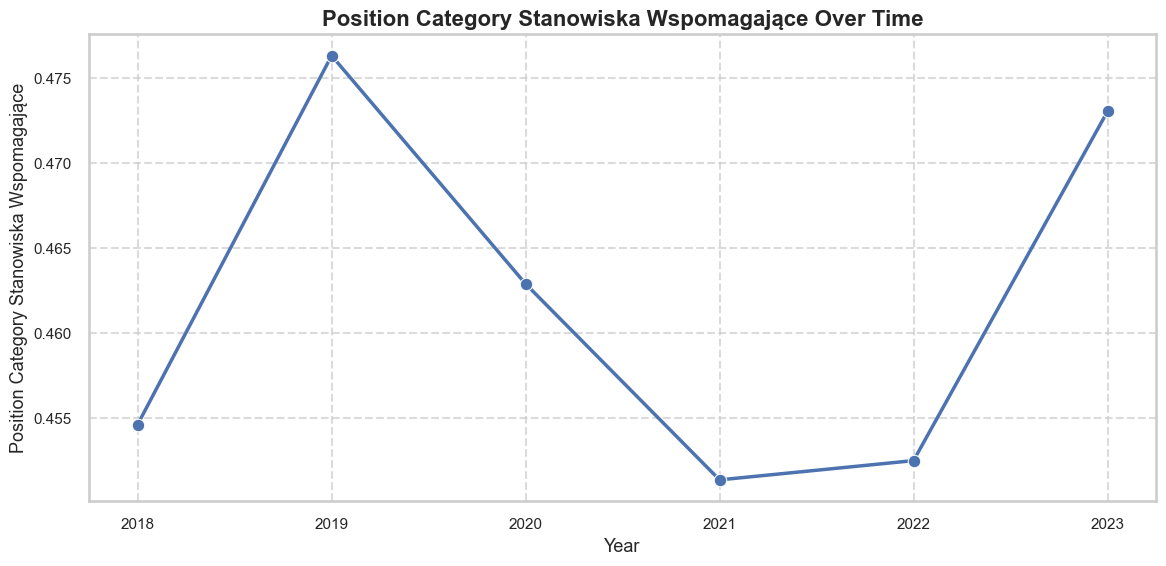

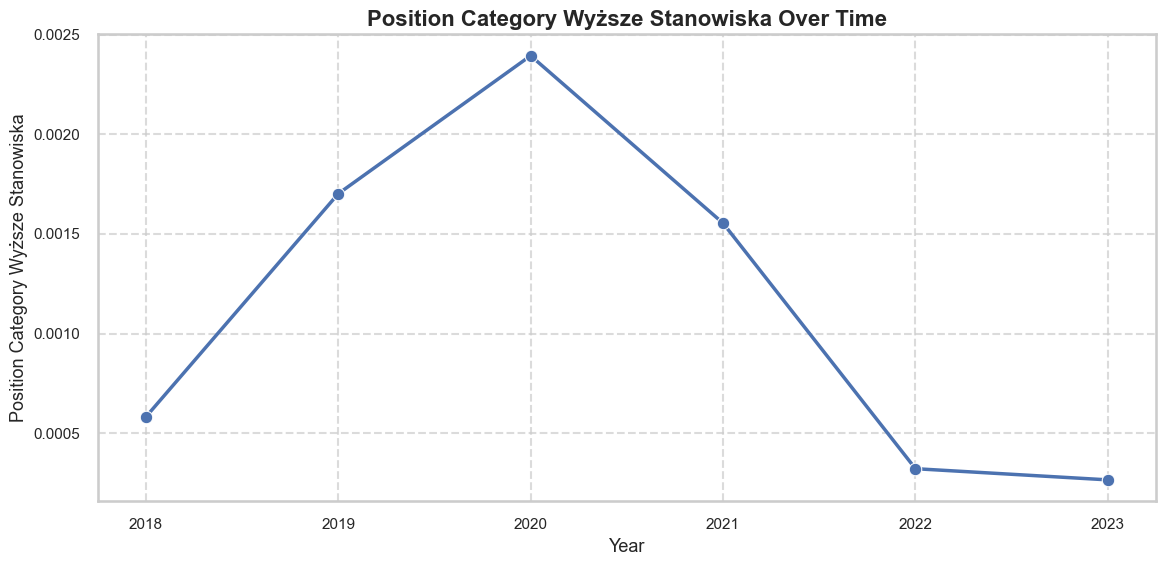

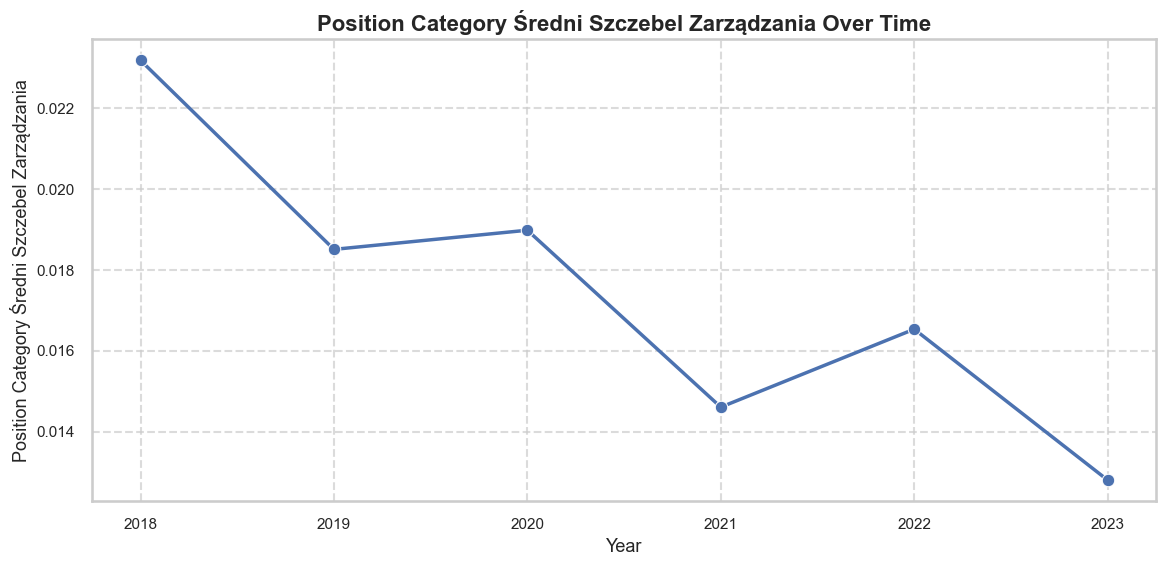

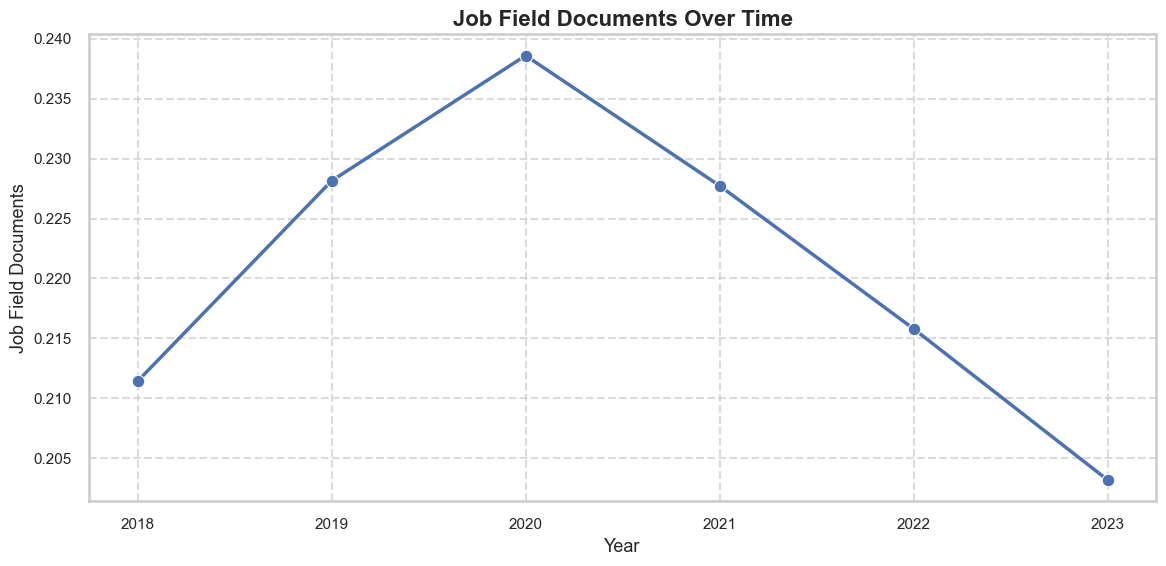

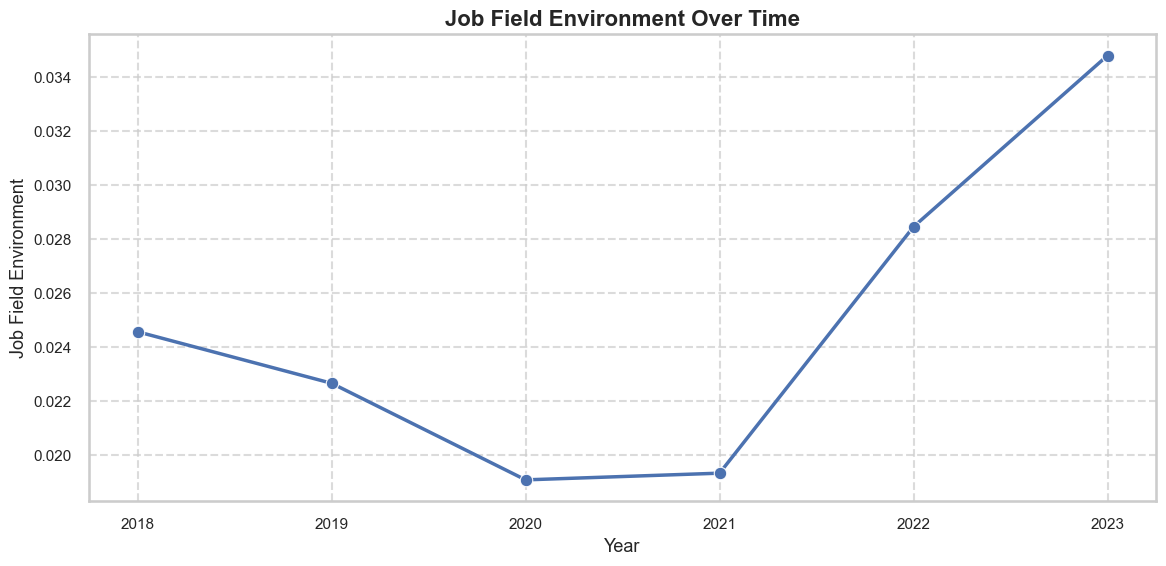

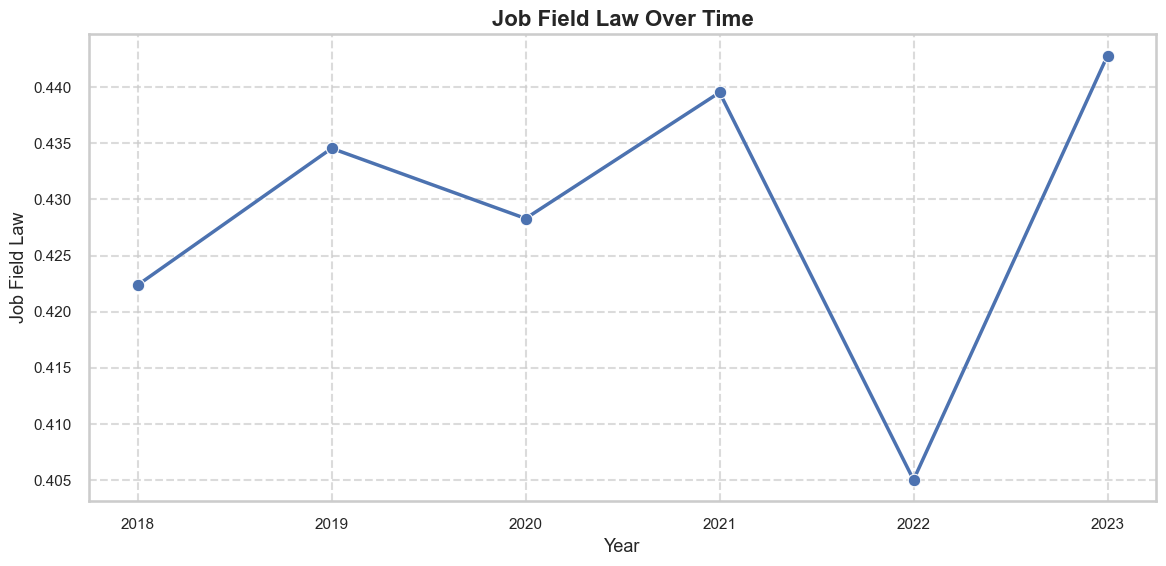

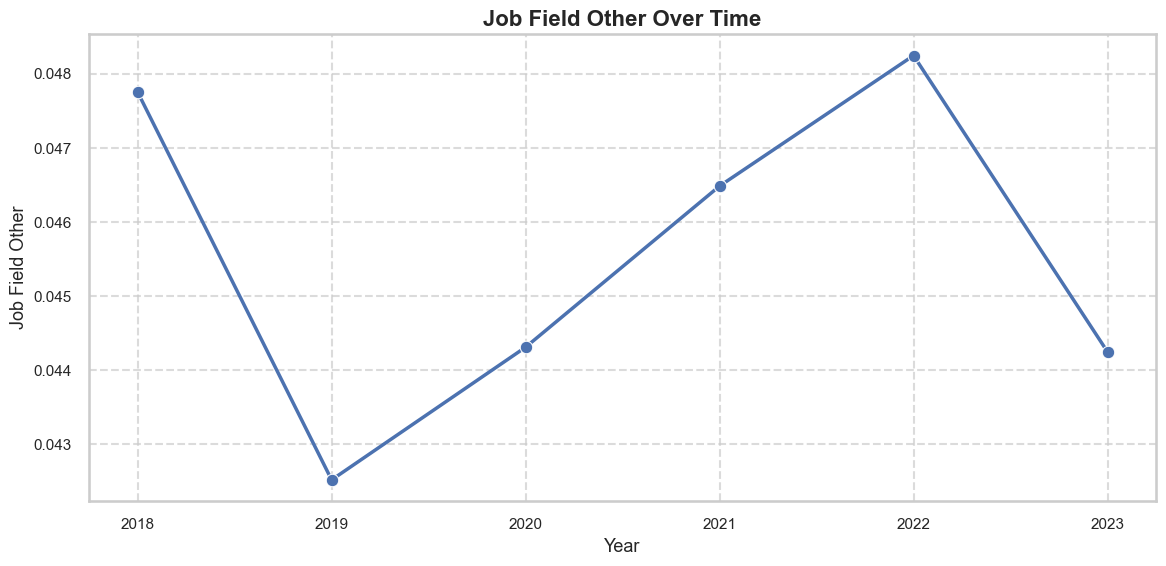

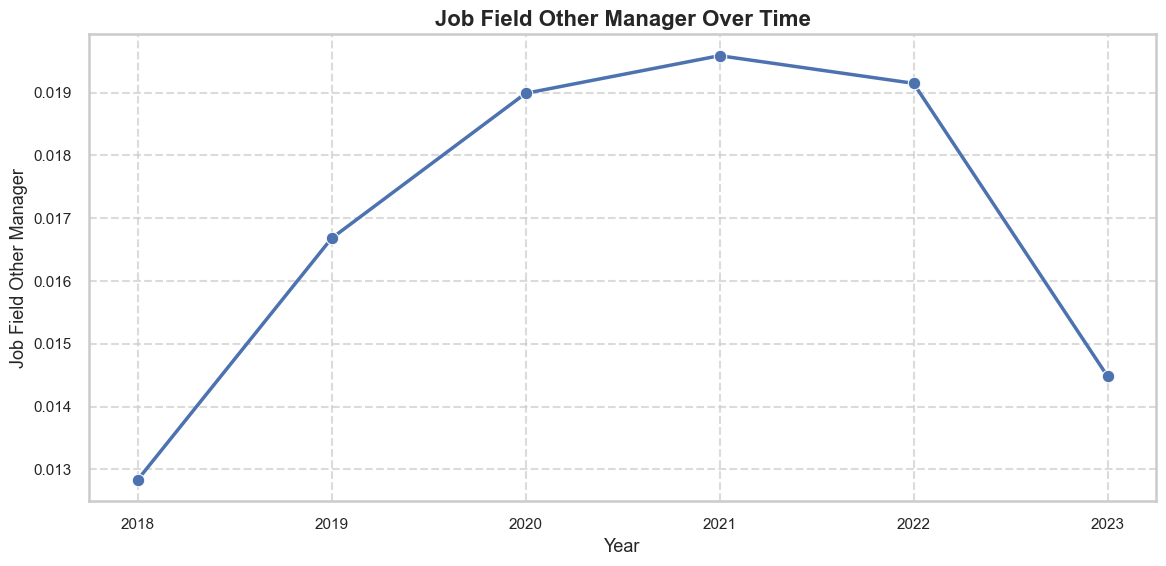

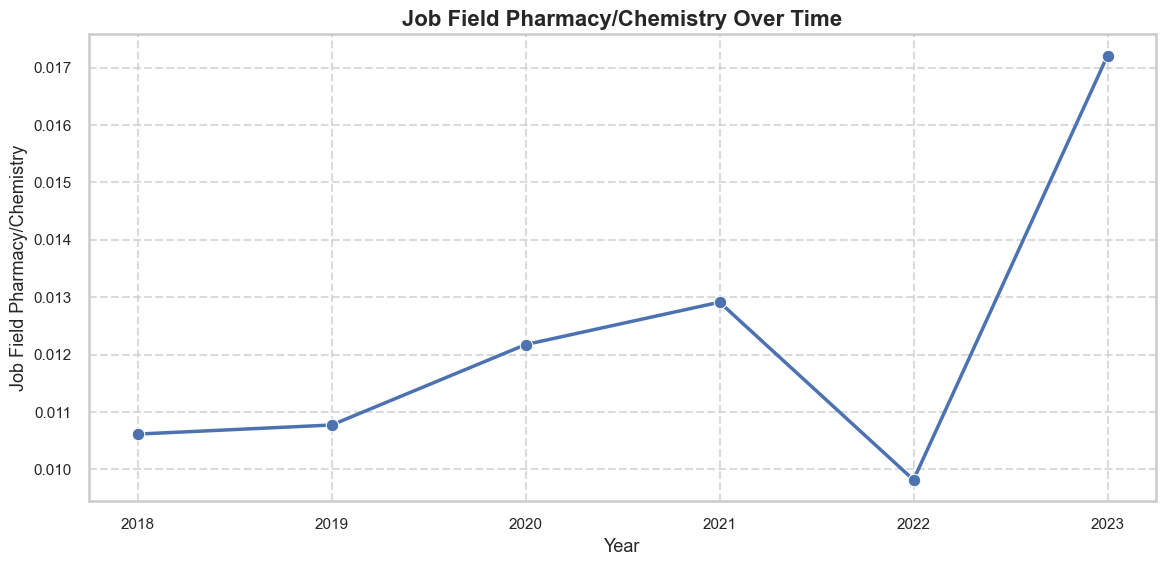

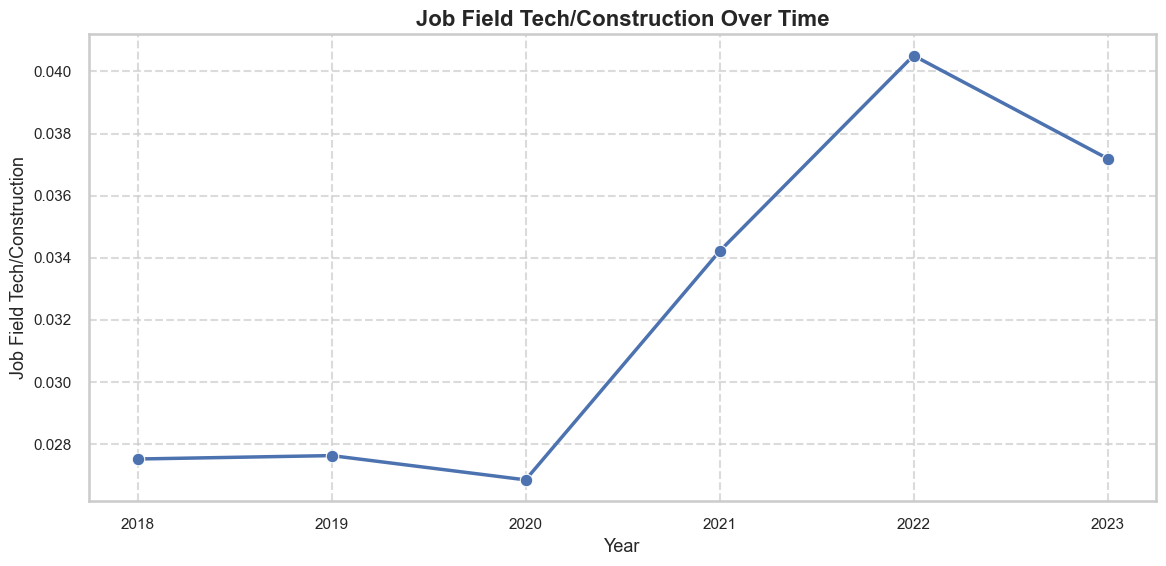

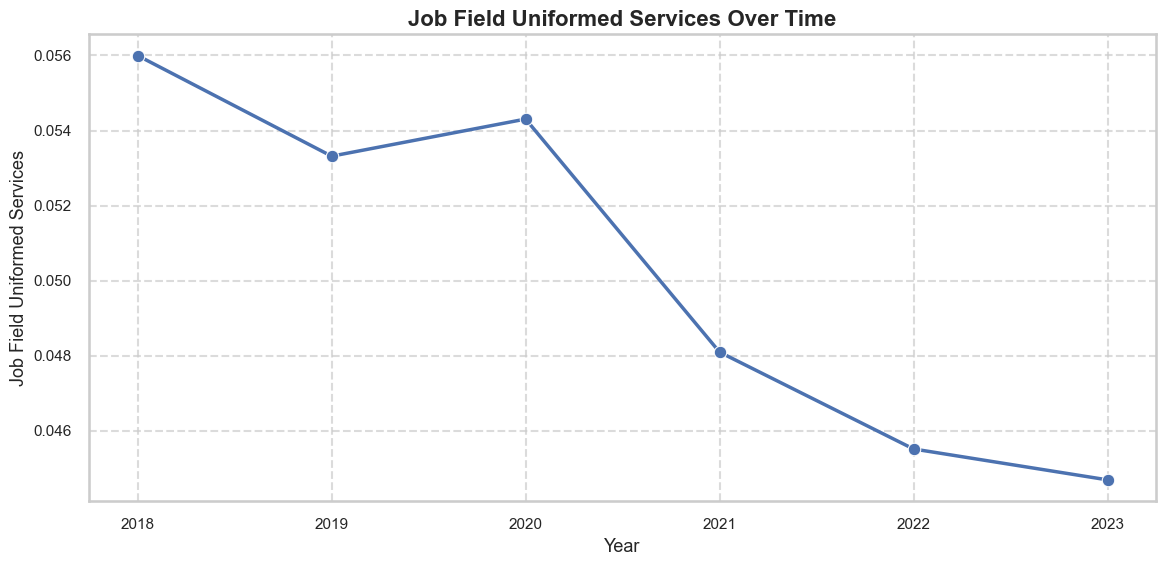

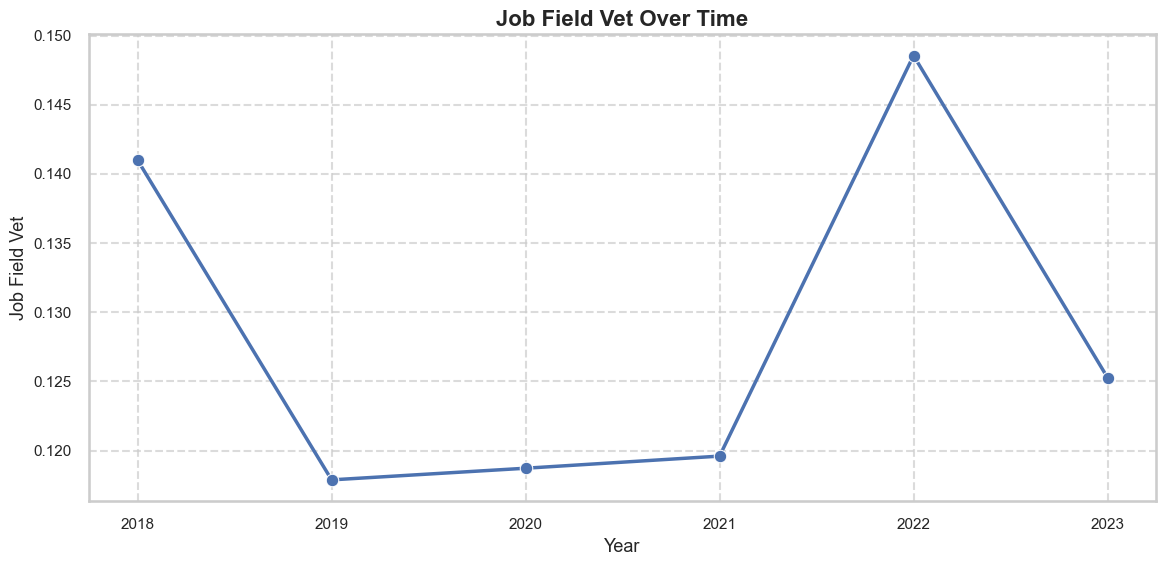

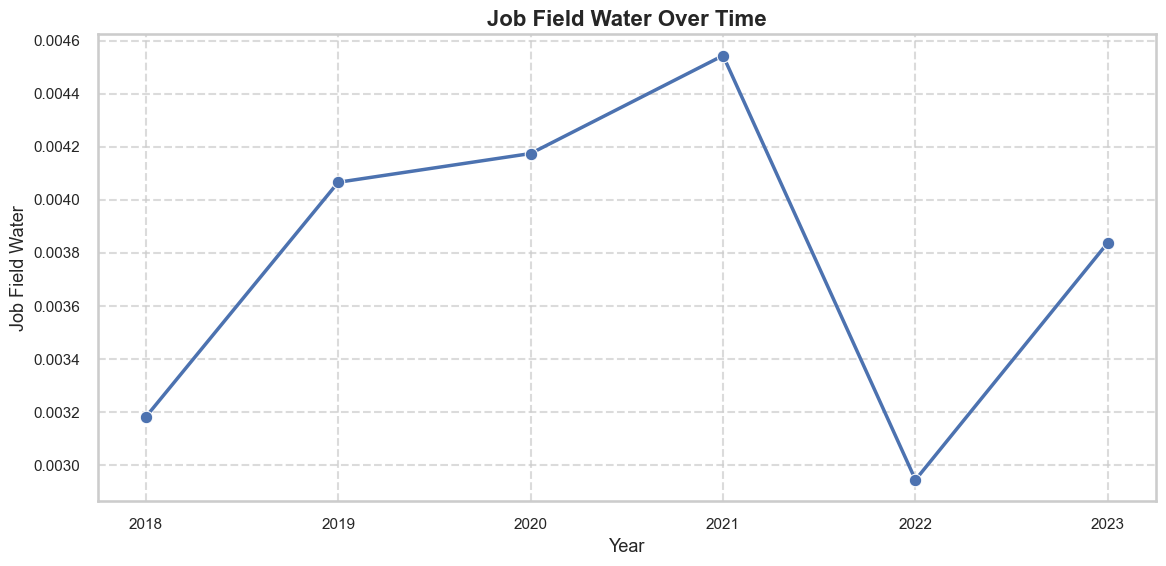

In [17]:
def plot_individual_time_series(dataframe):
    exclude_columns = ['voivodeship', 'district', 'education_level', 'work_time', 'institution']
    df_grouped = dataframe.groupby('year').mean(numeric_only=True)
    columns_to_plot = [col for col in df_grouped.columns if col not in exclude_columns]

    sns.set(style="whitegrid", context="talk", palette="deep")

    for column in columns_to_plot:
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=df_grouped.index, y=df_grouped[column], marker='o', linewidth=2.5)
        plt.title(f"{column.replace('_', ' ').title()} Over Time", fontsize=16, weight='bold')
        plt.xlabel("Year", fontsize=13)
        plt.ylabel(column.replace('_', ' ').title(), fontsize=13)
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)
        plt.grid(visible=True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
plot_individual_time_series(df_for_charts)

##### Variability charts

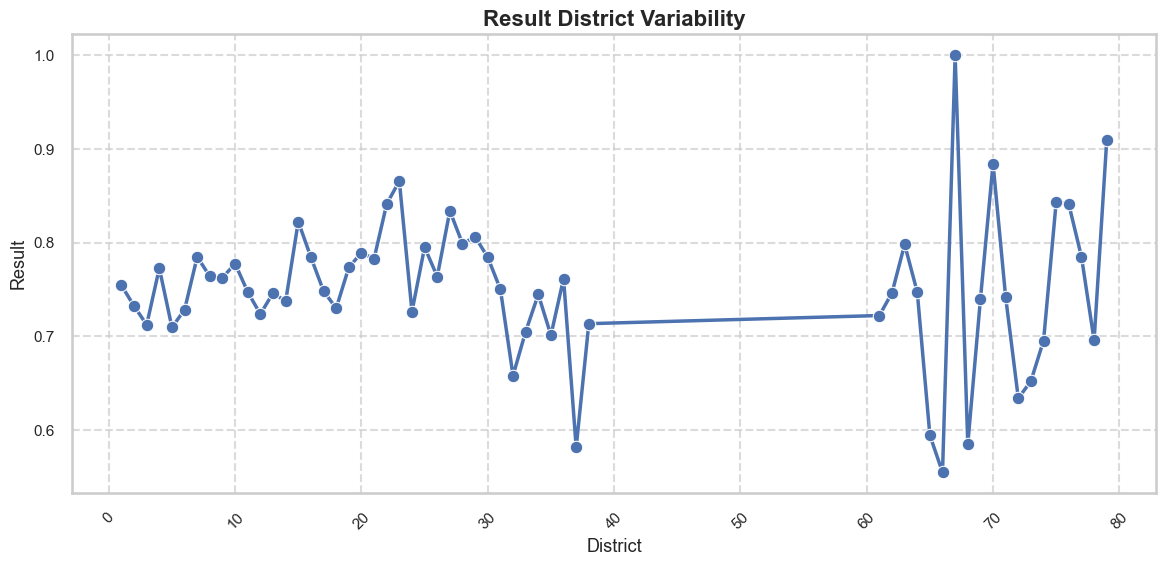

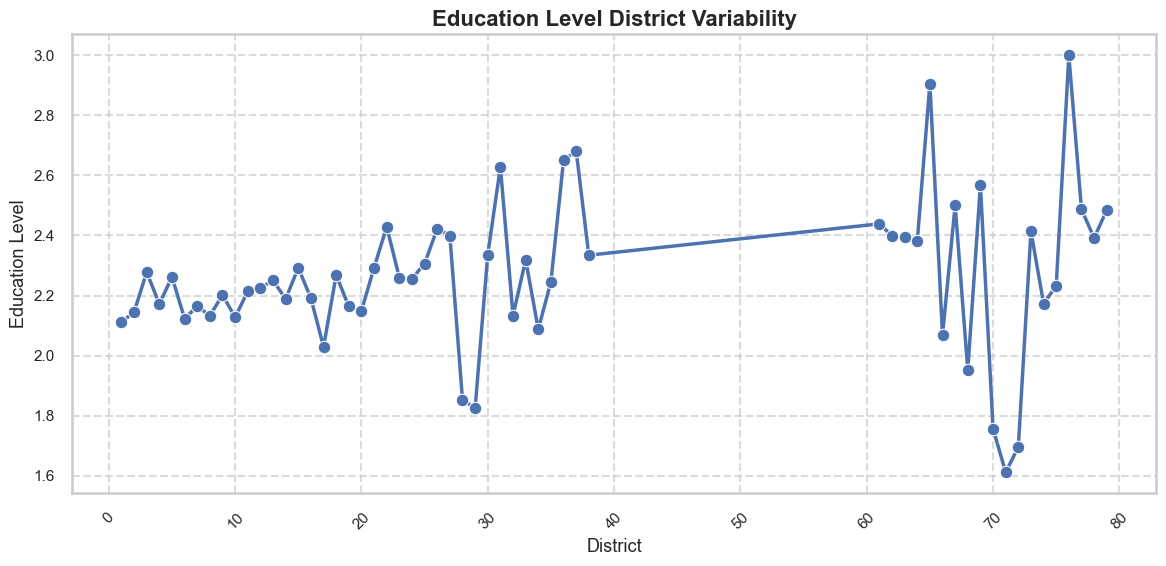

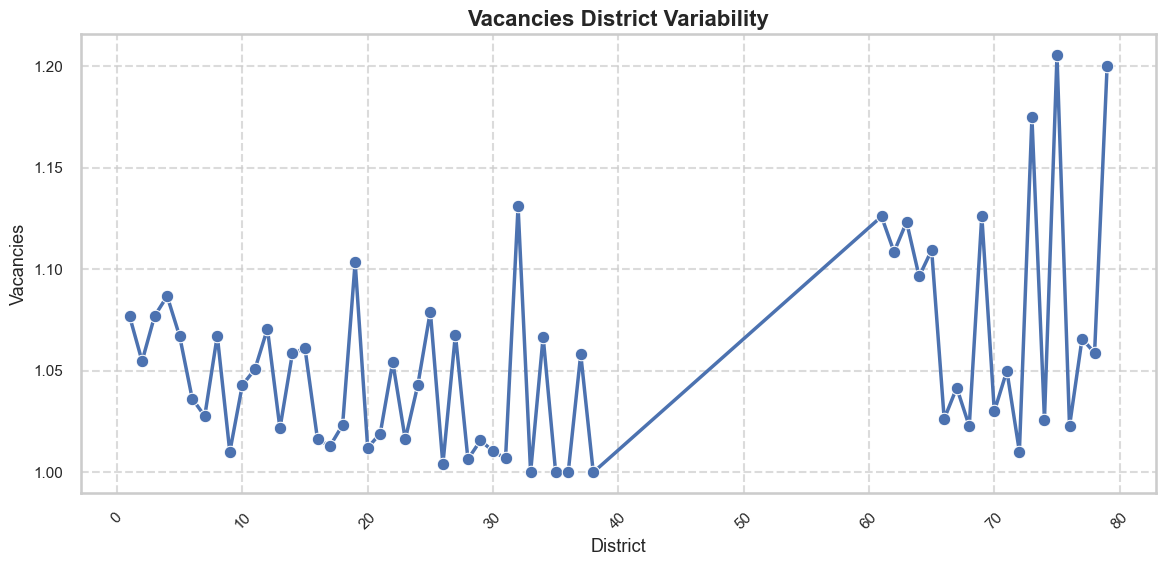

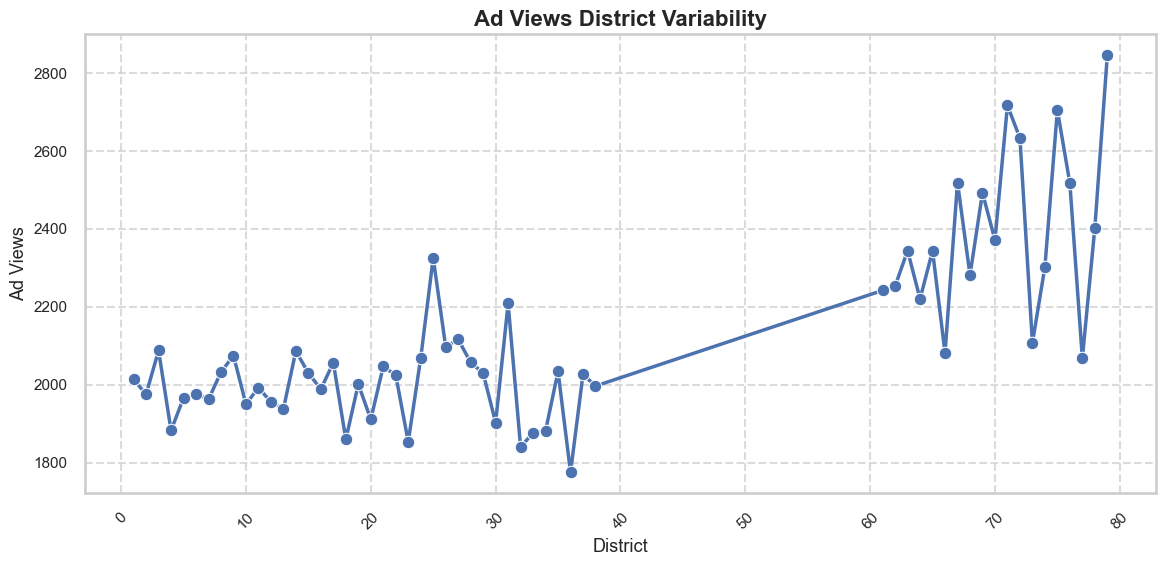

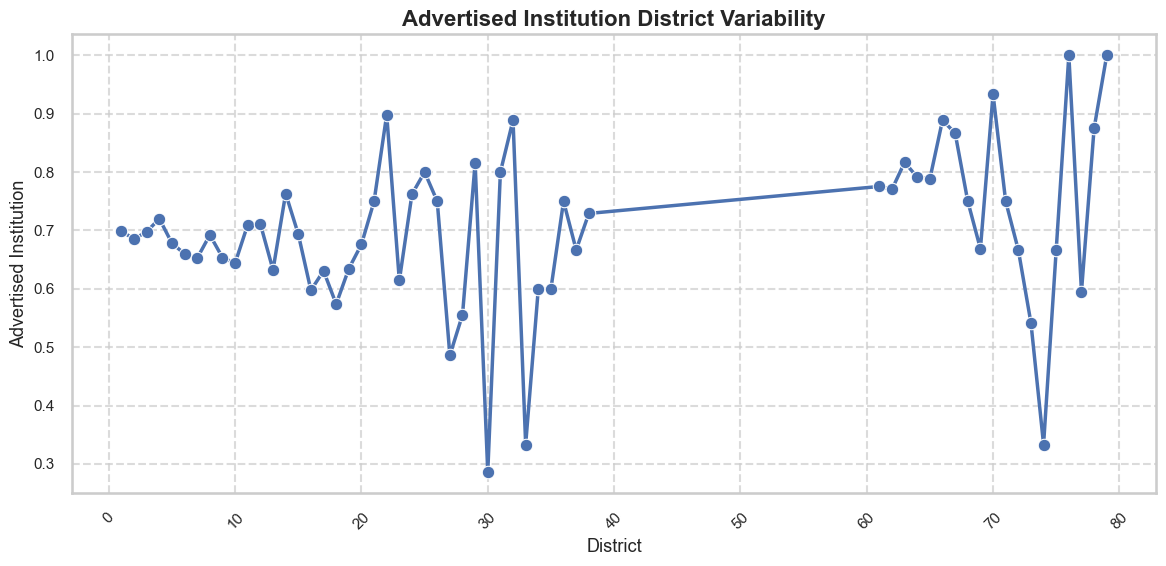

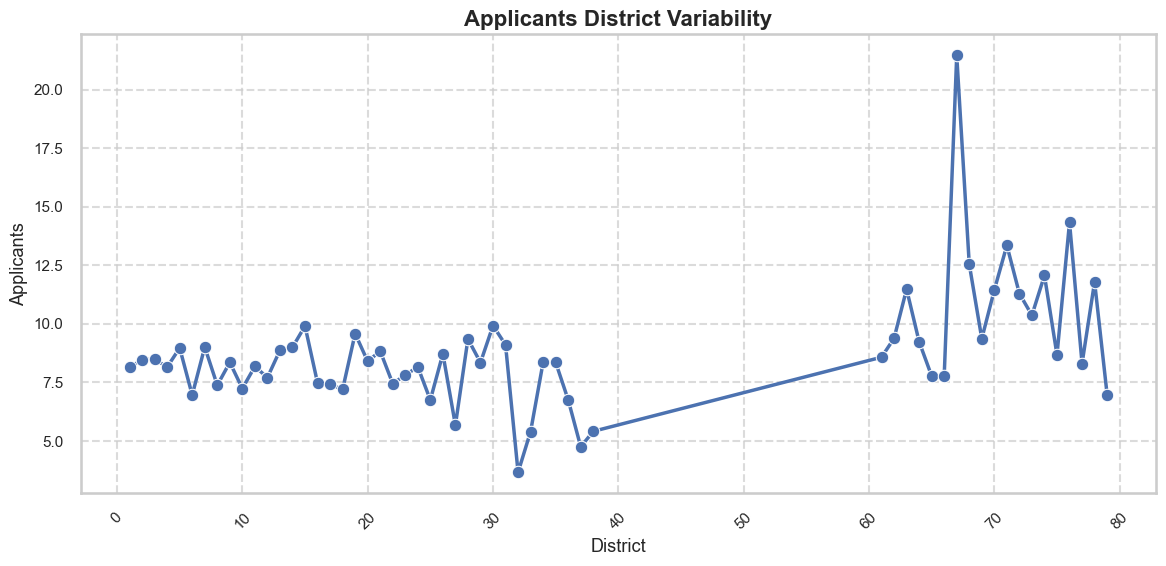

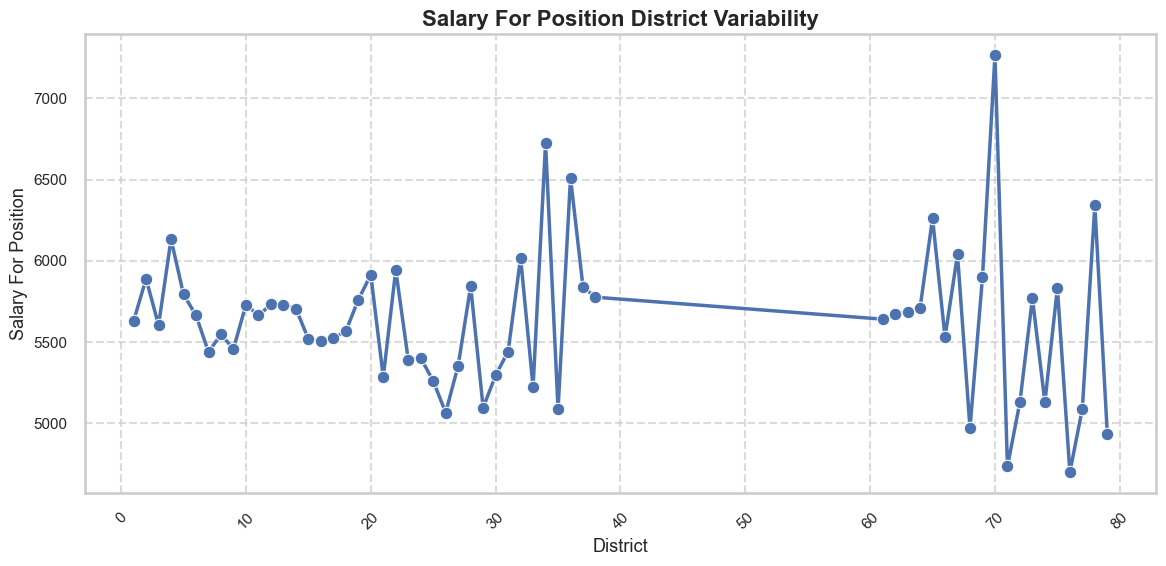

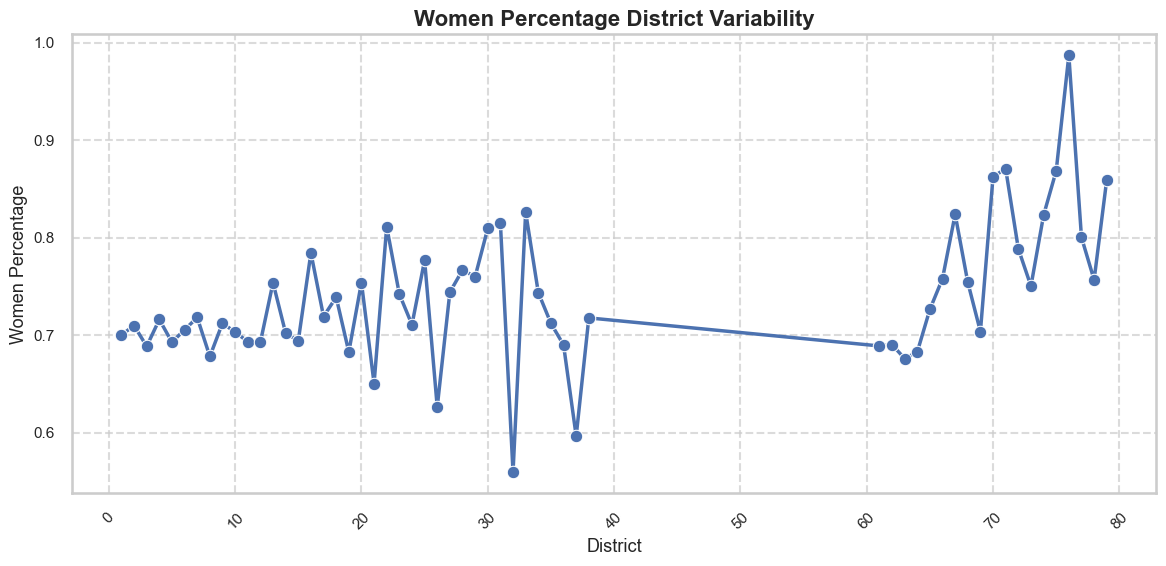

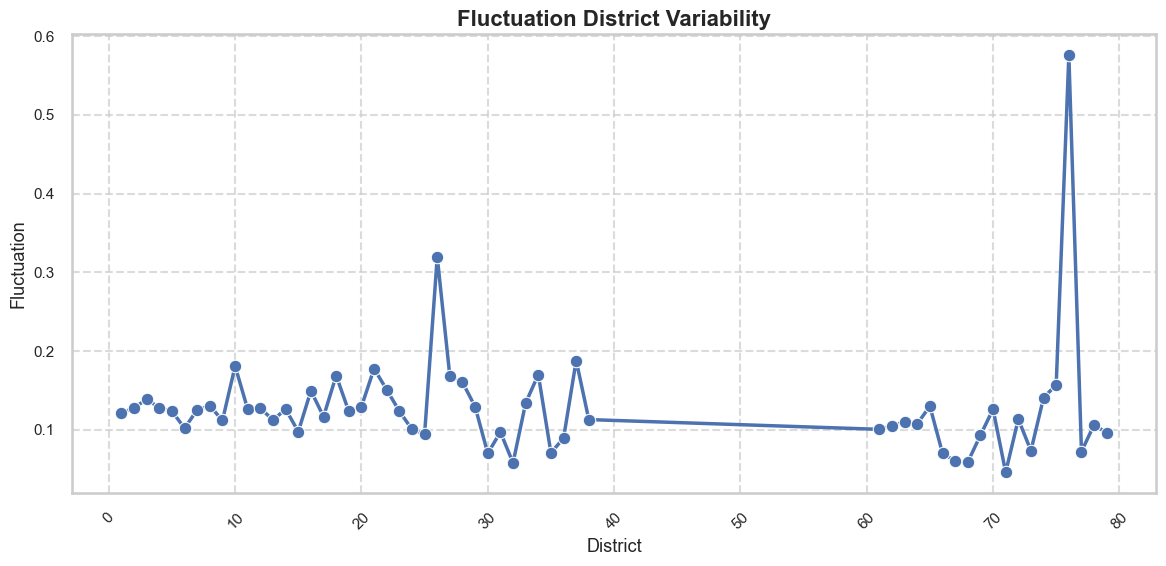

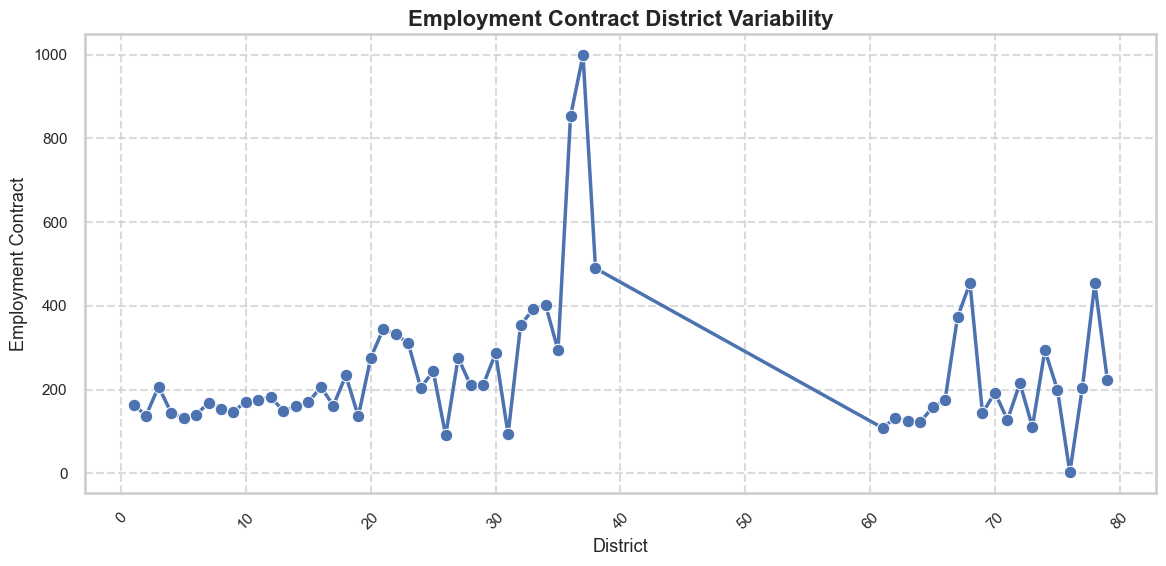

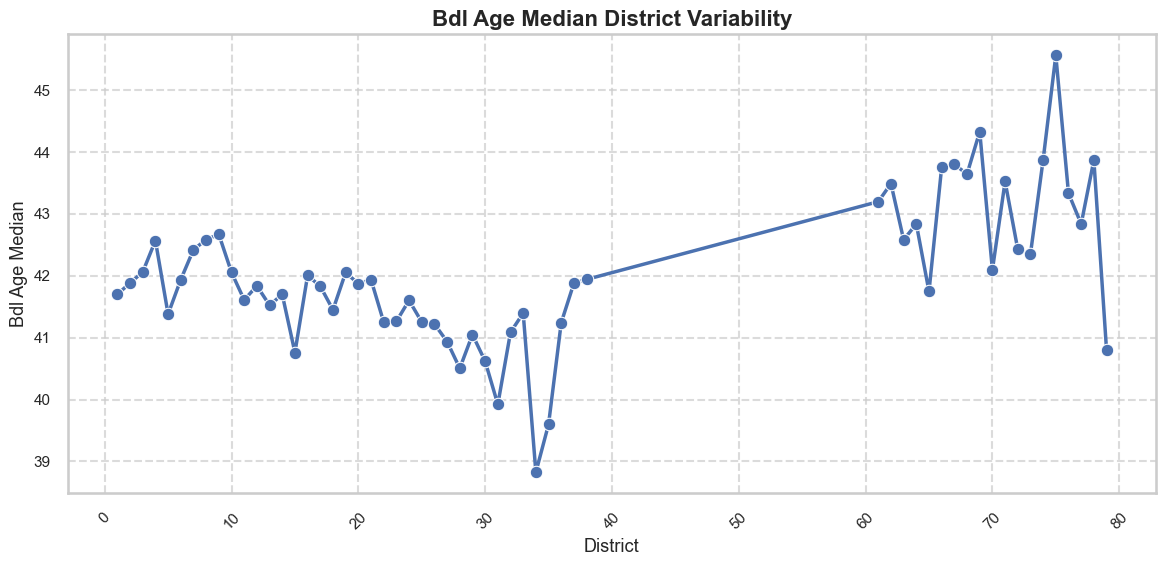

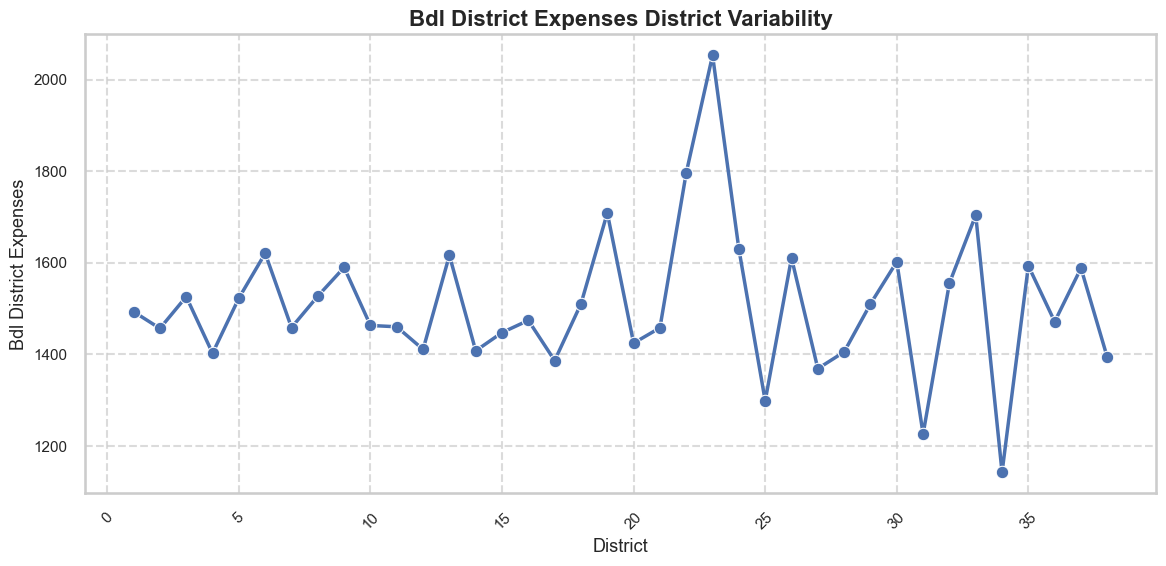

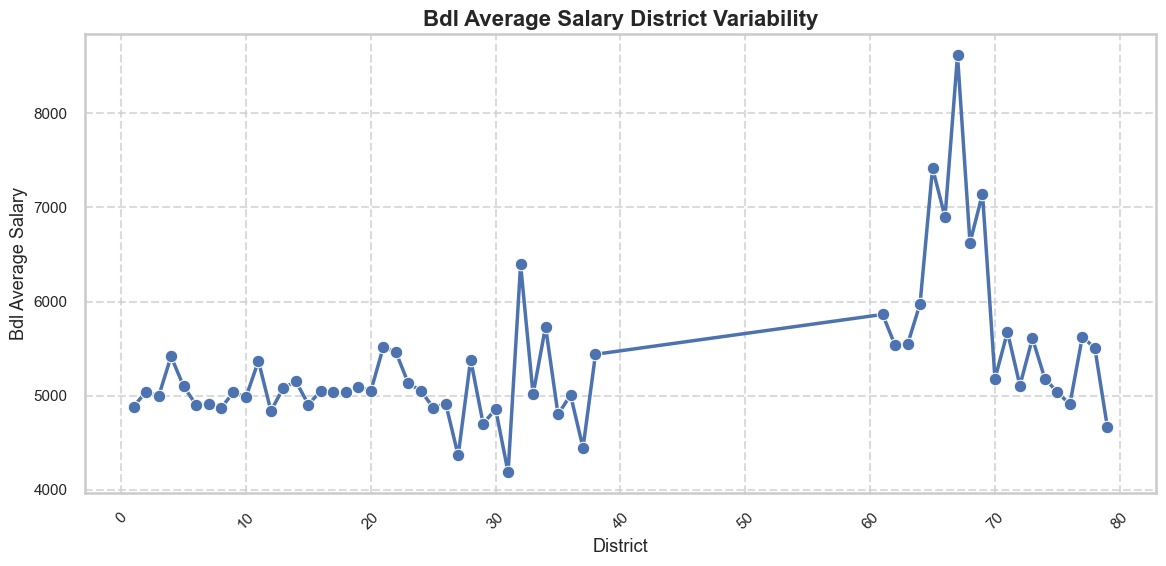

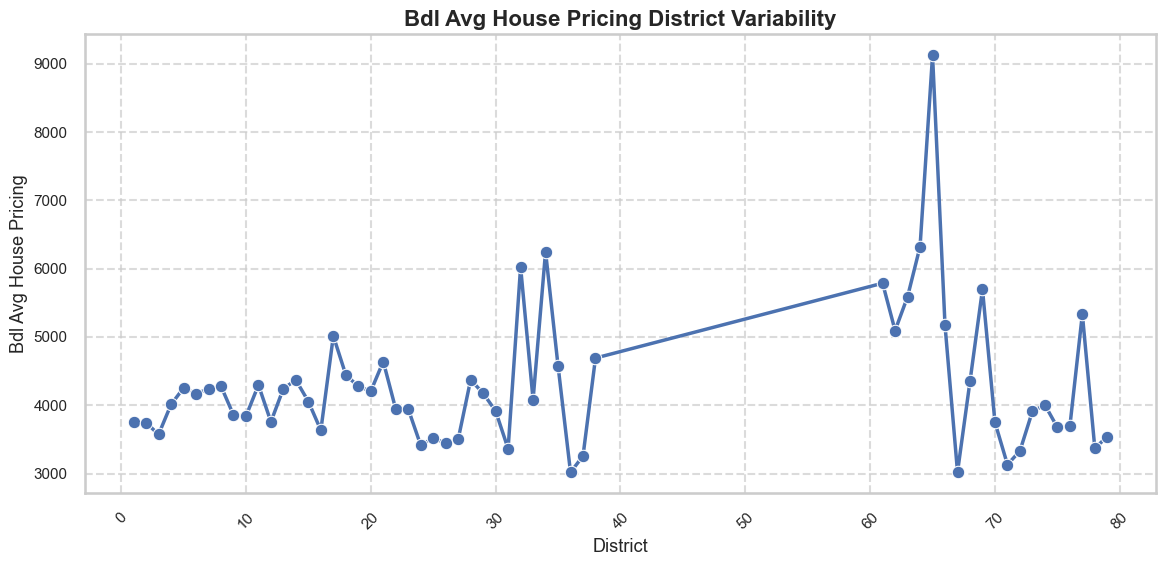

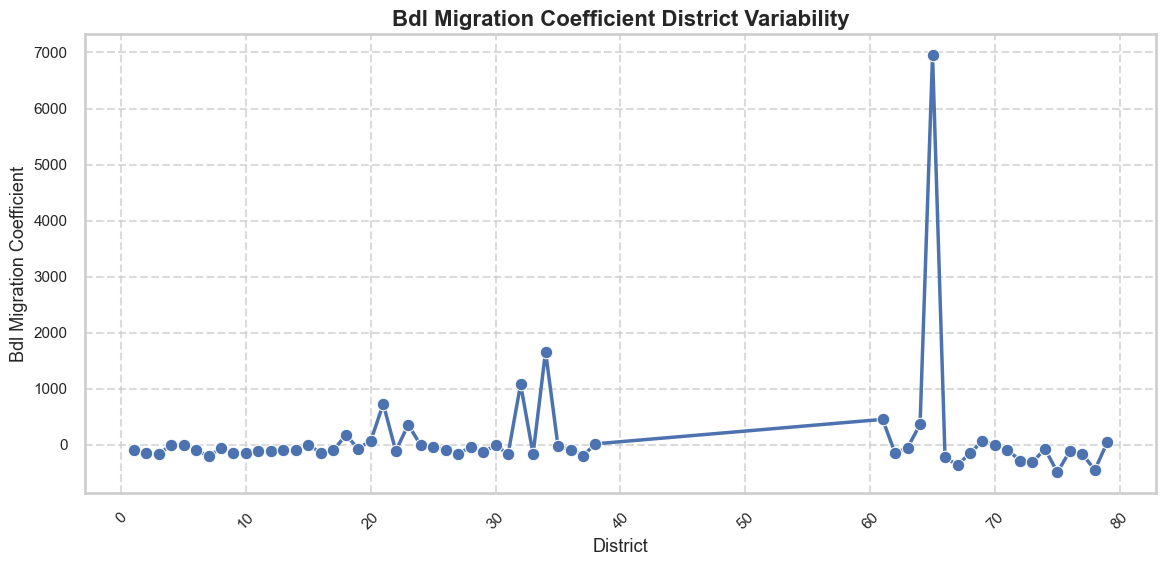

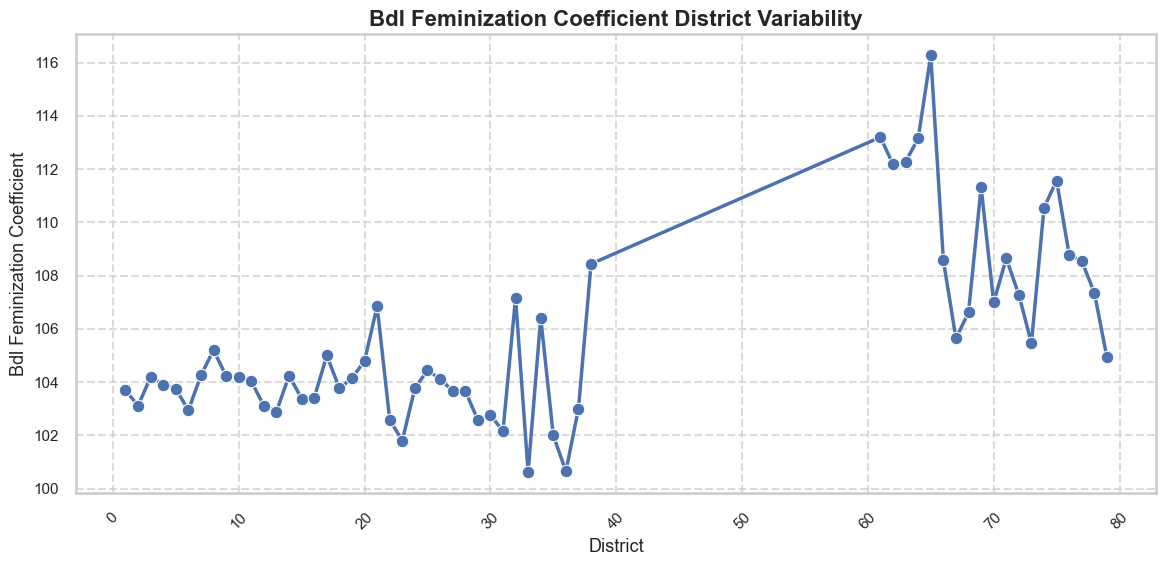

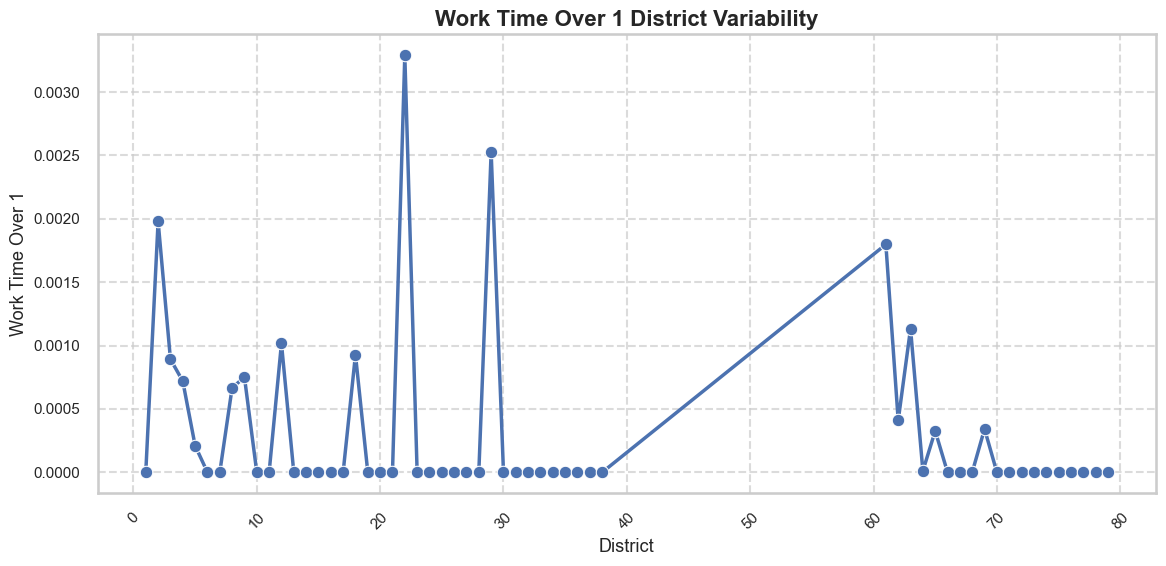

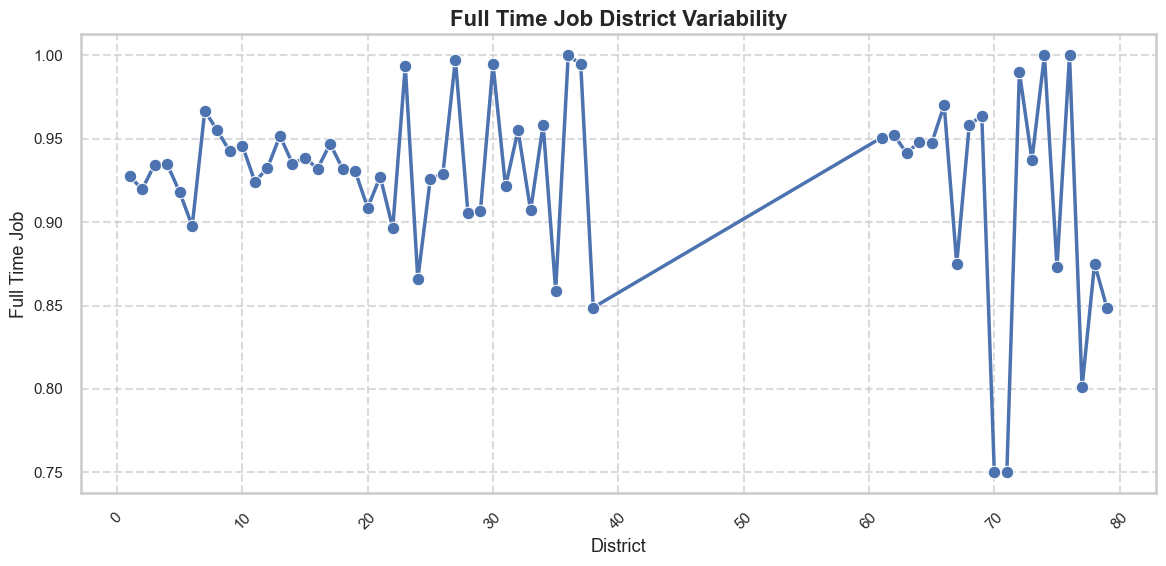

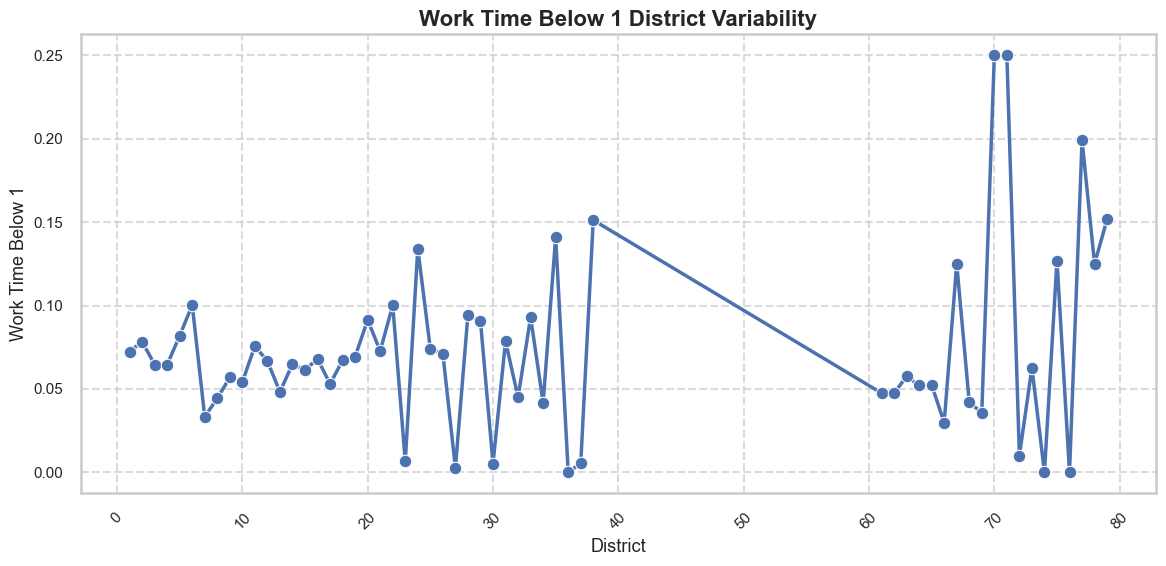

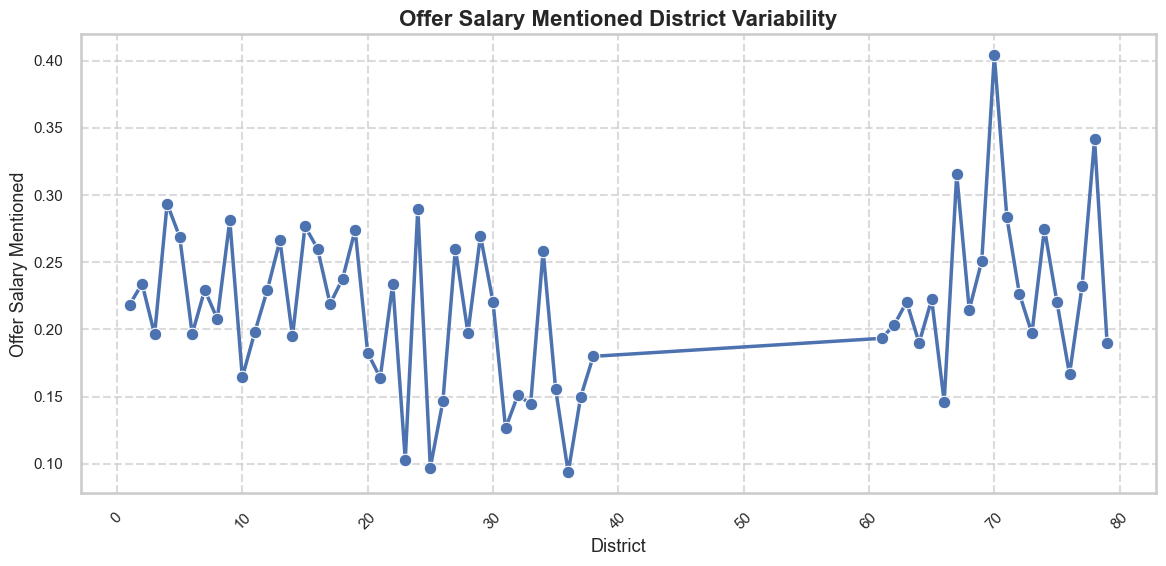

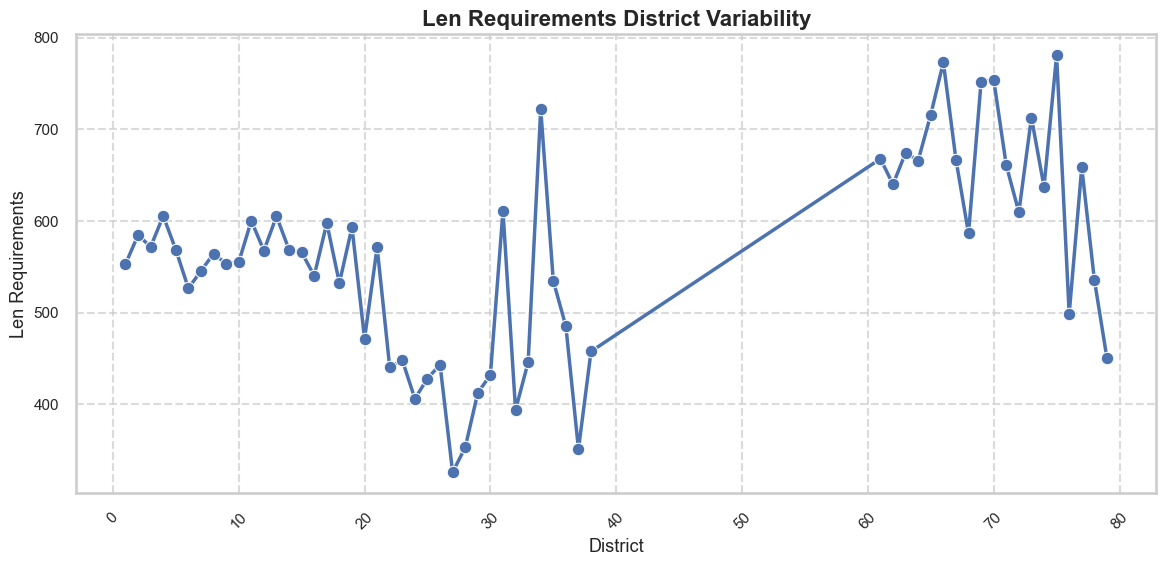

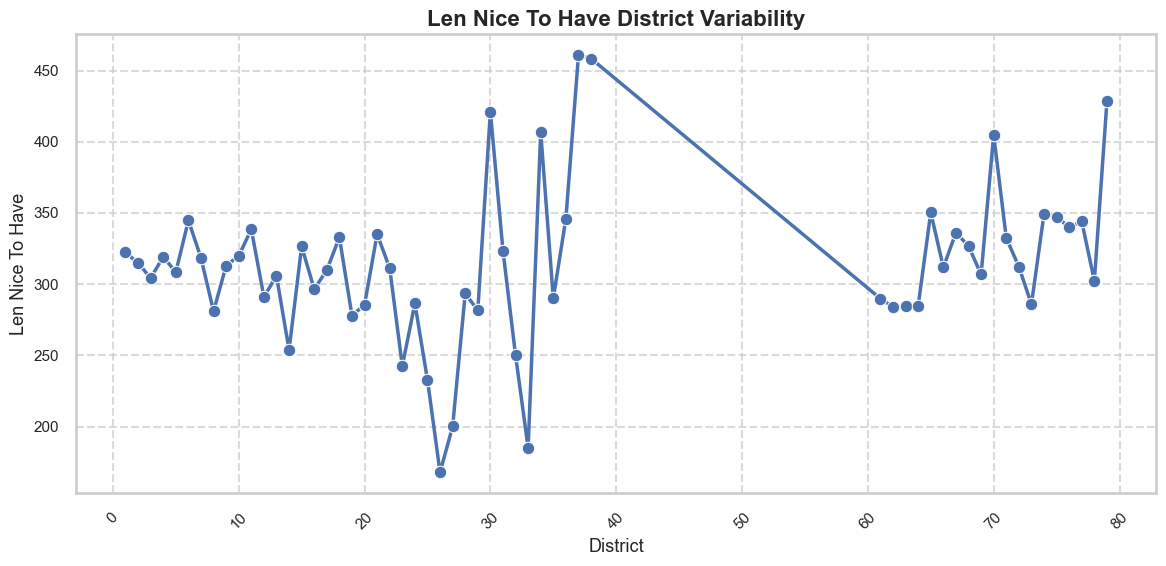

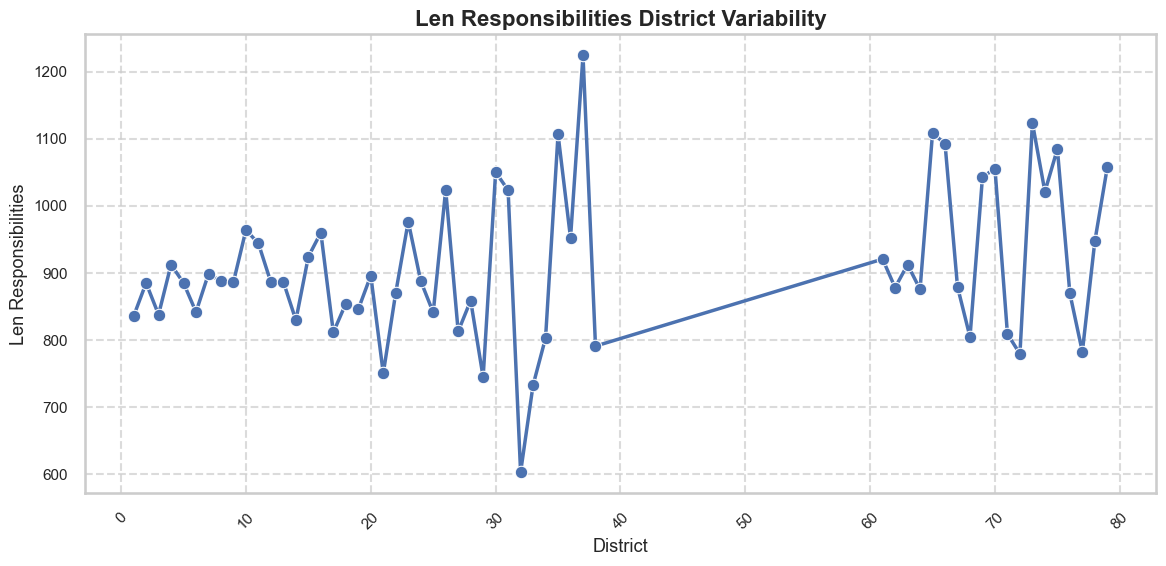

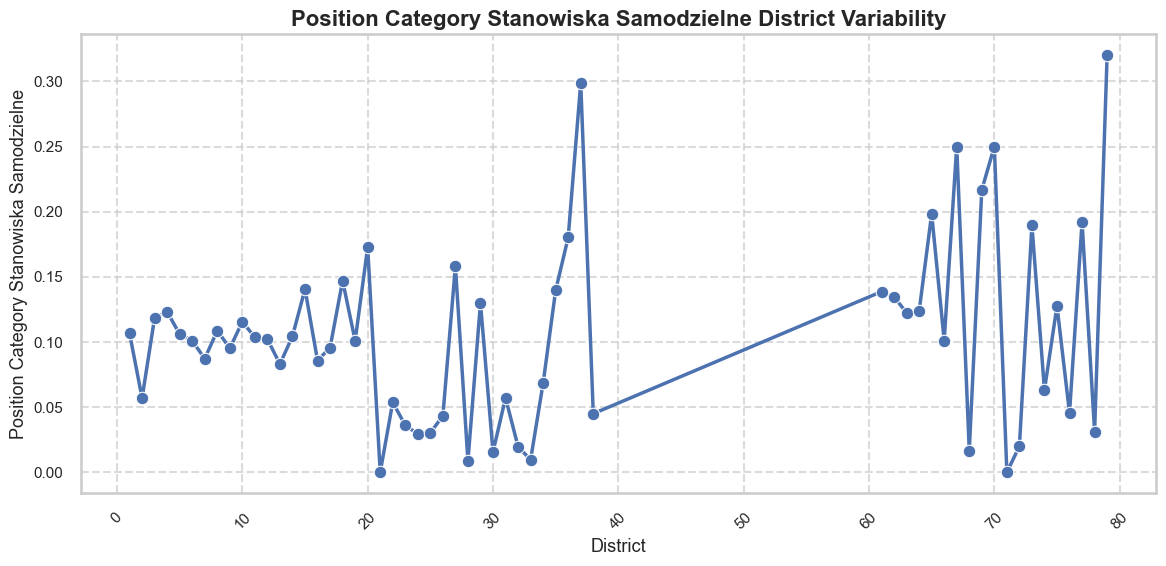

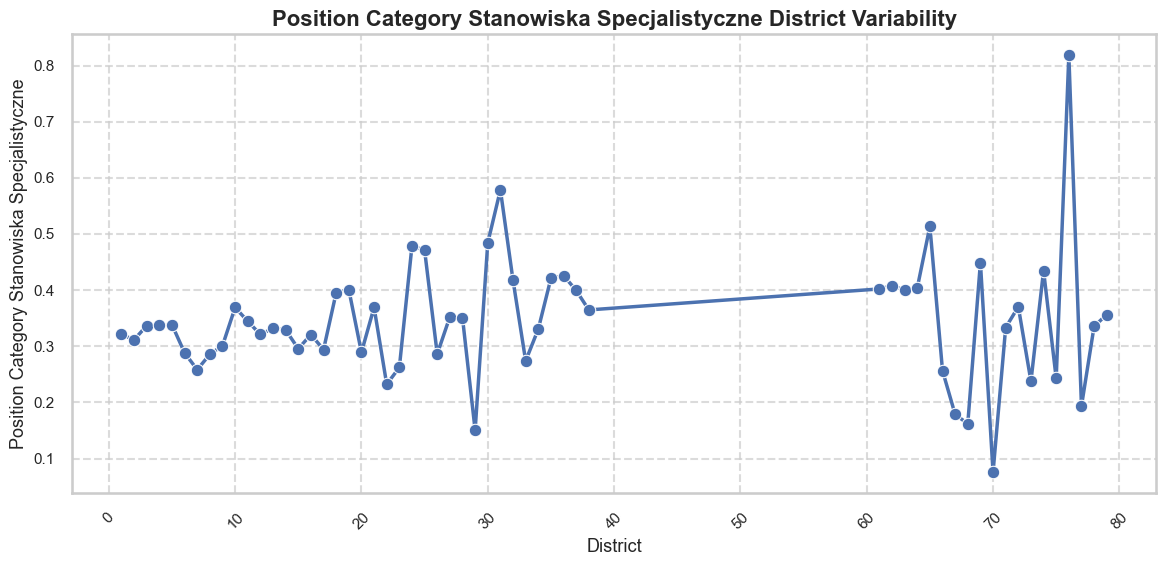

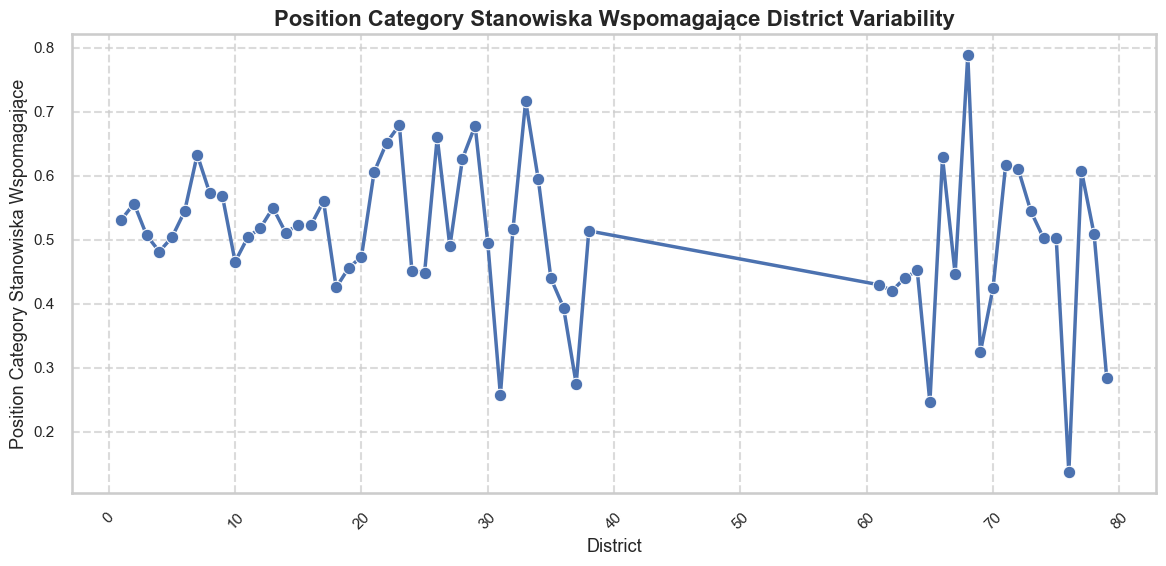

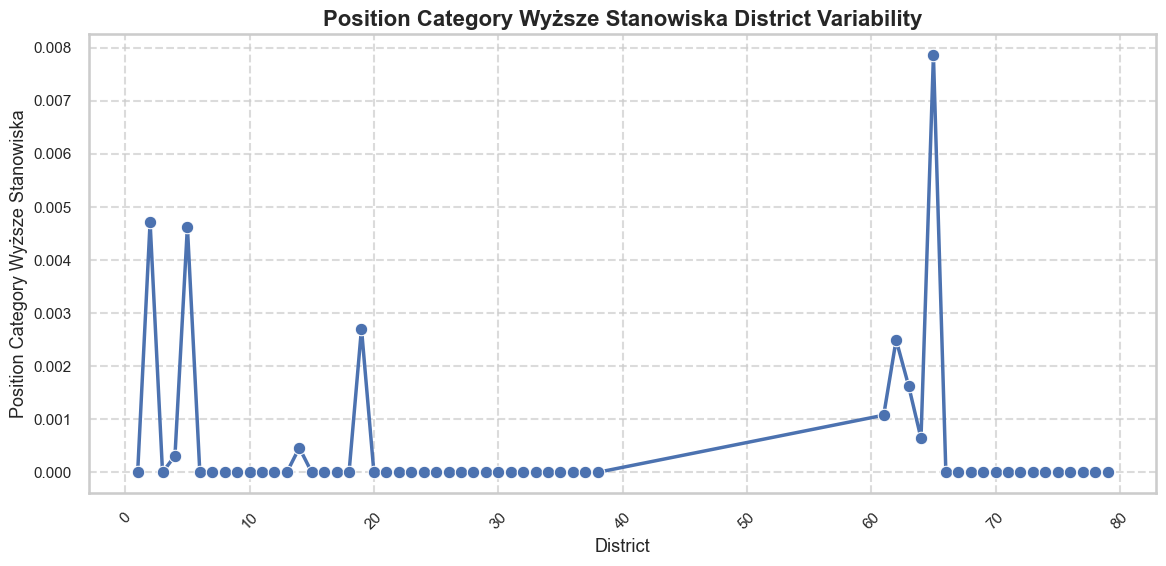

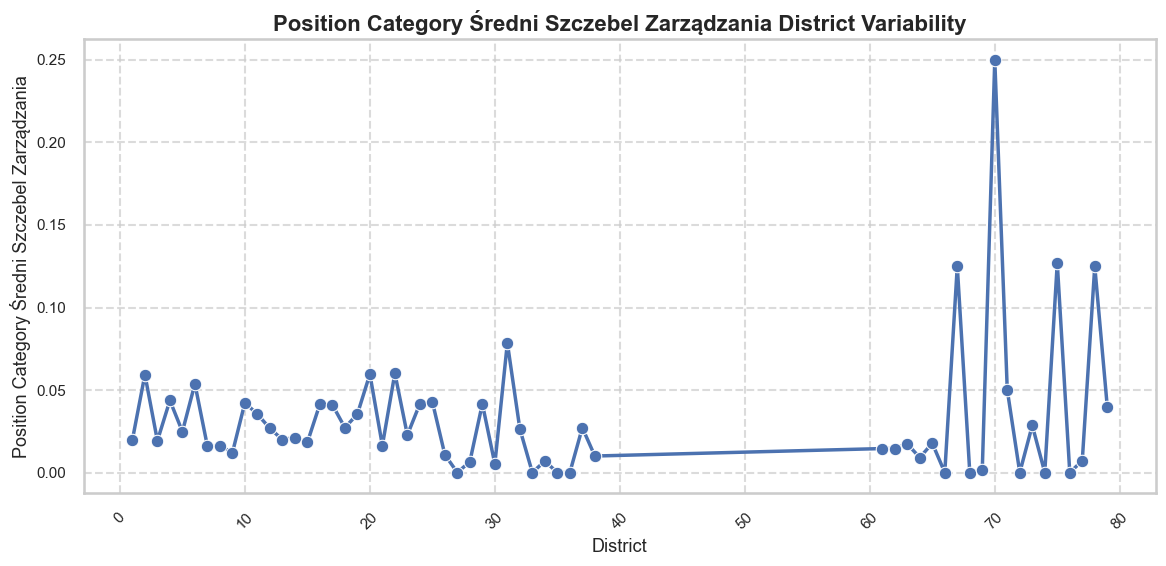

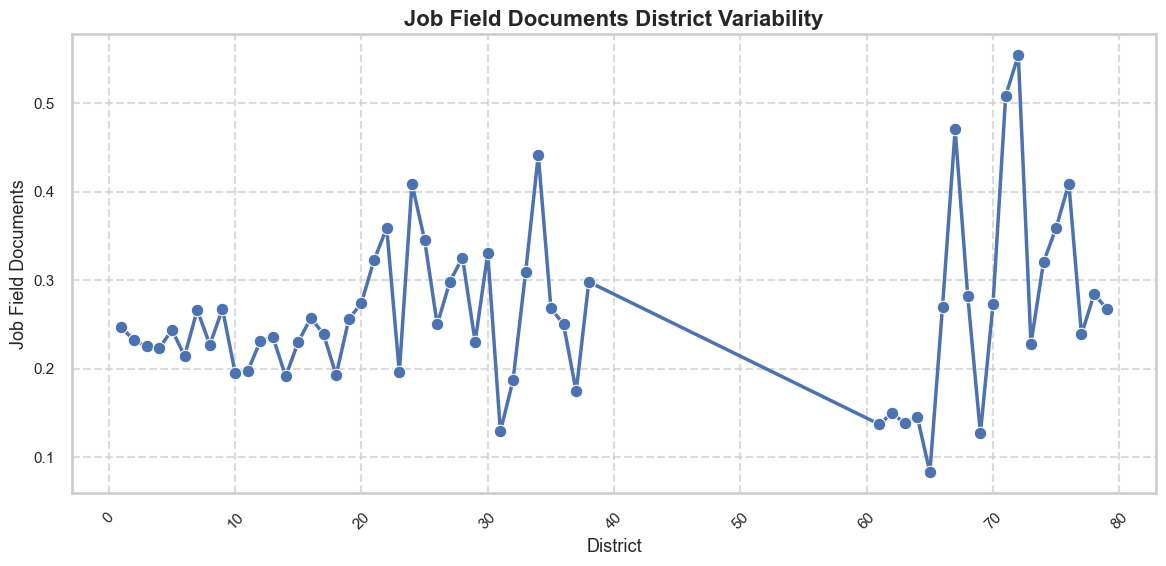

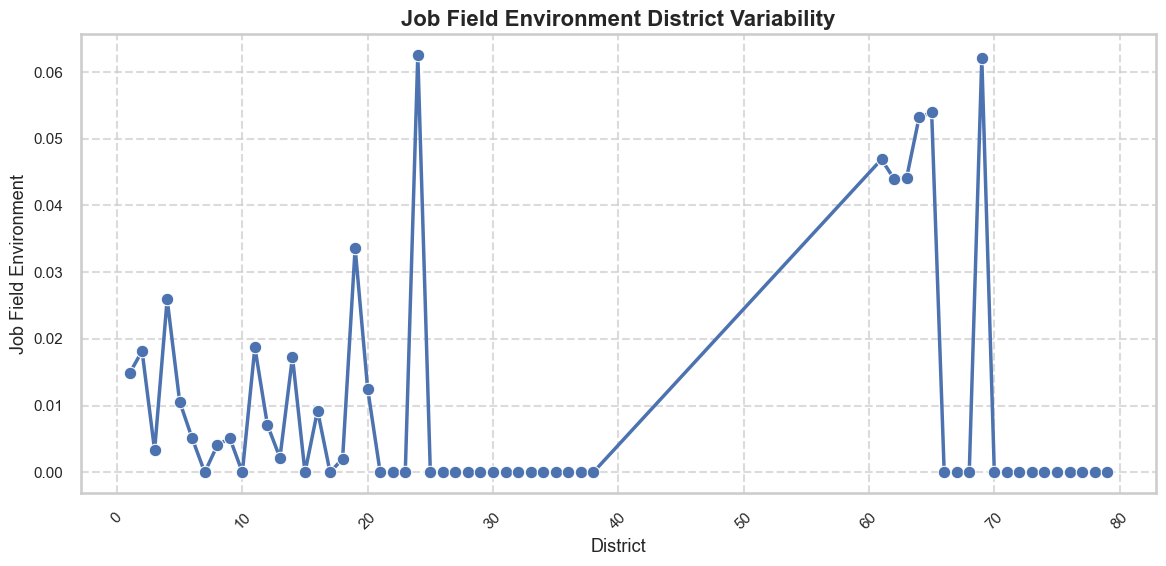

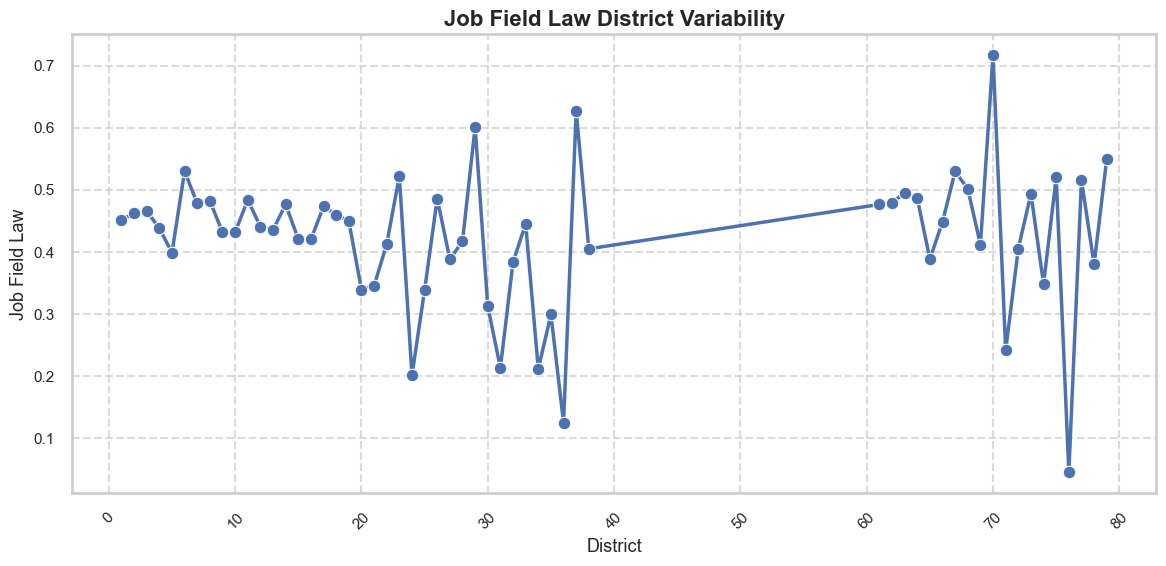

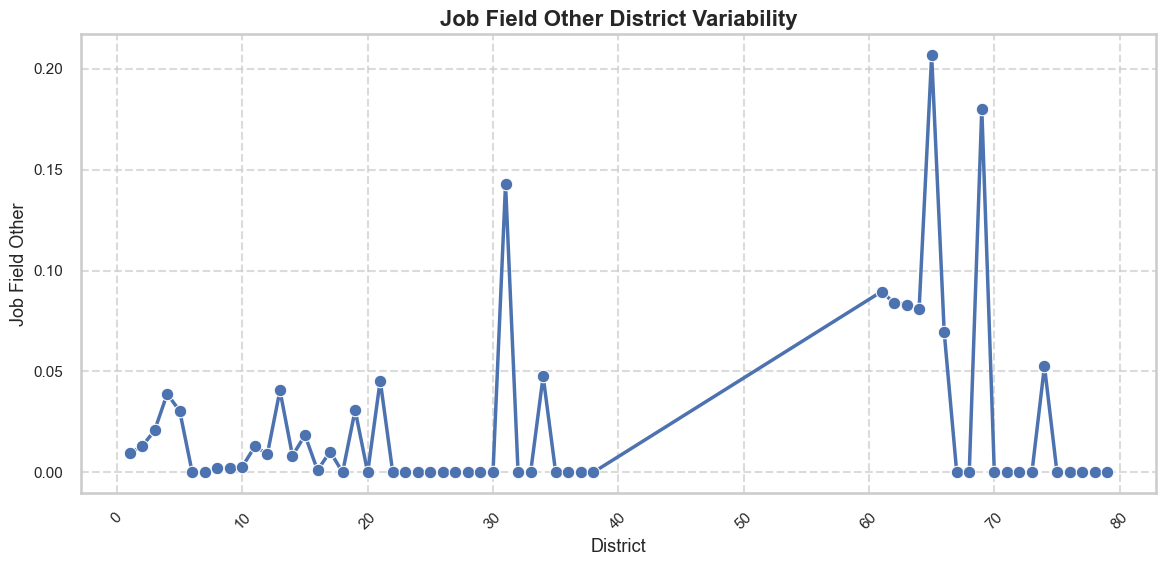

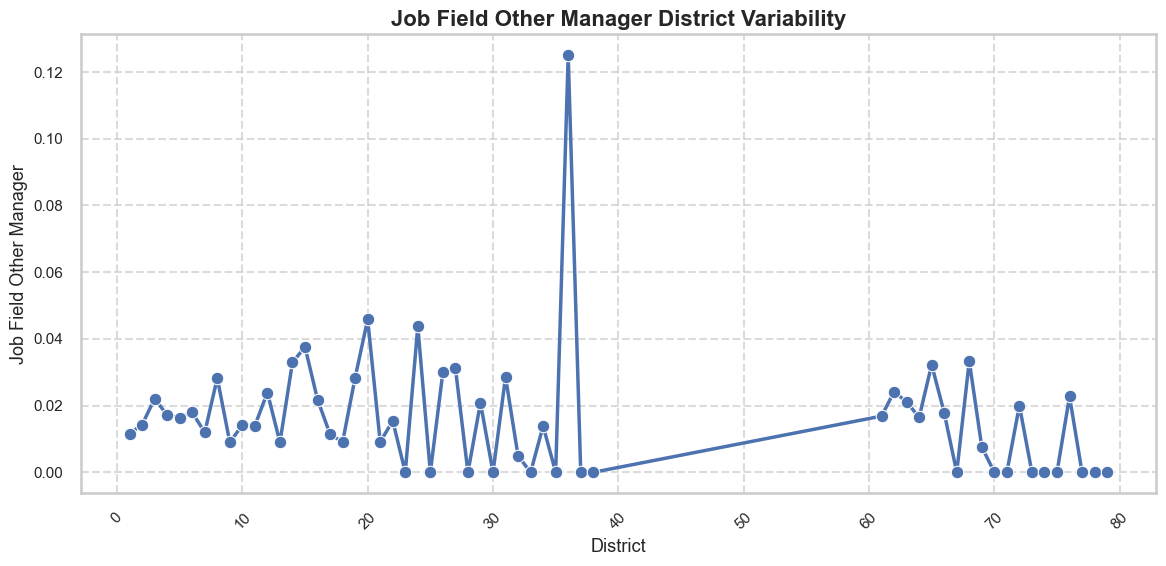

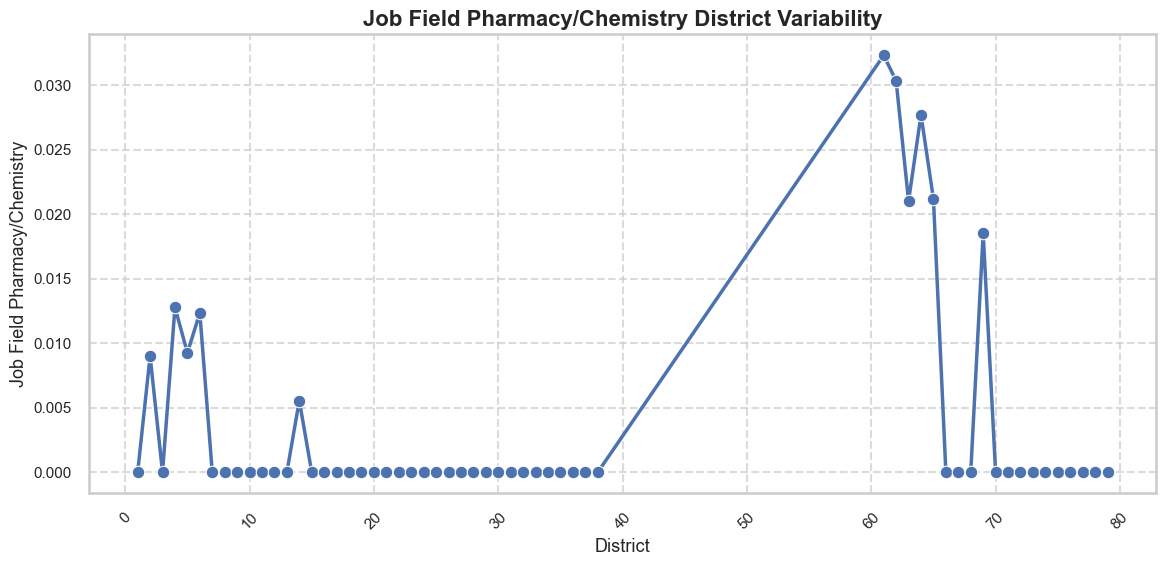

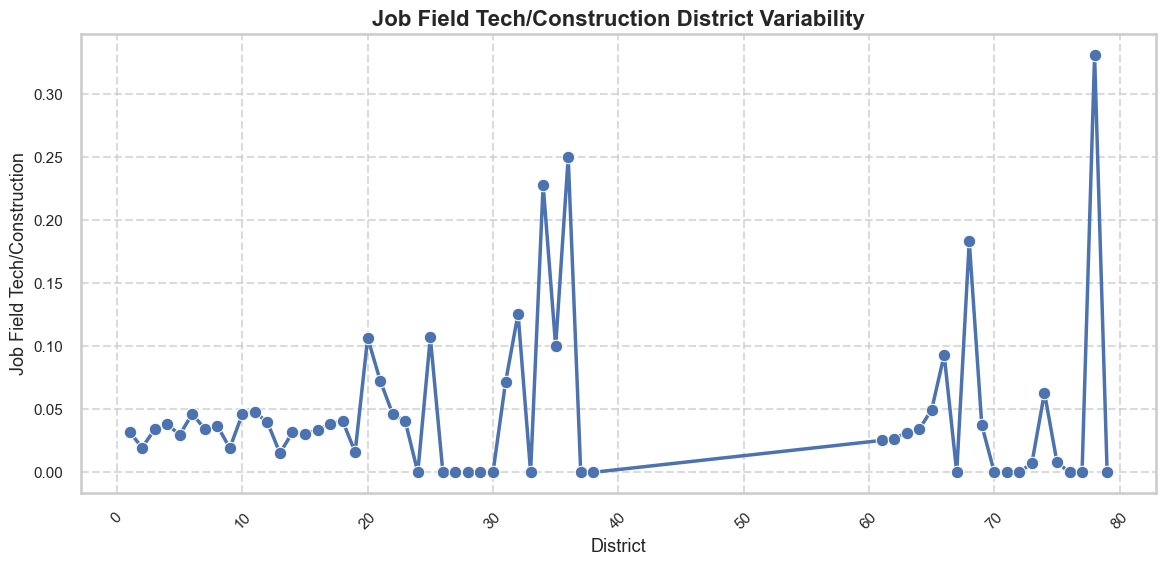

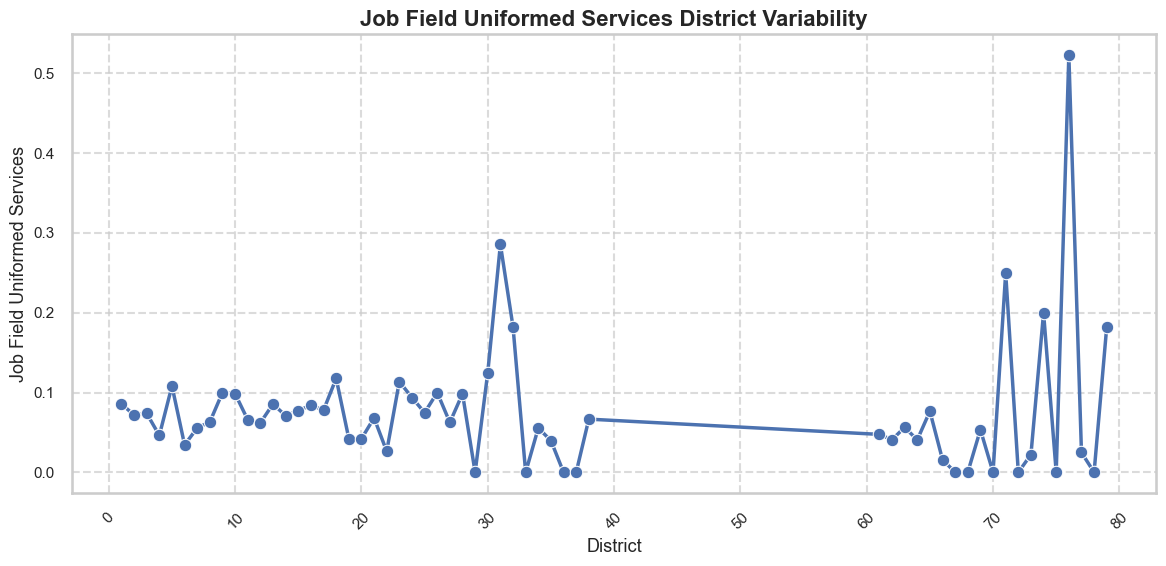

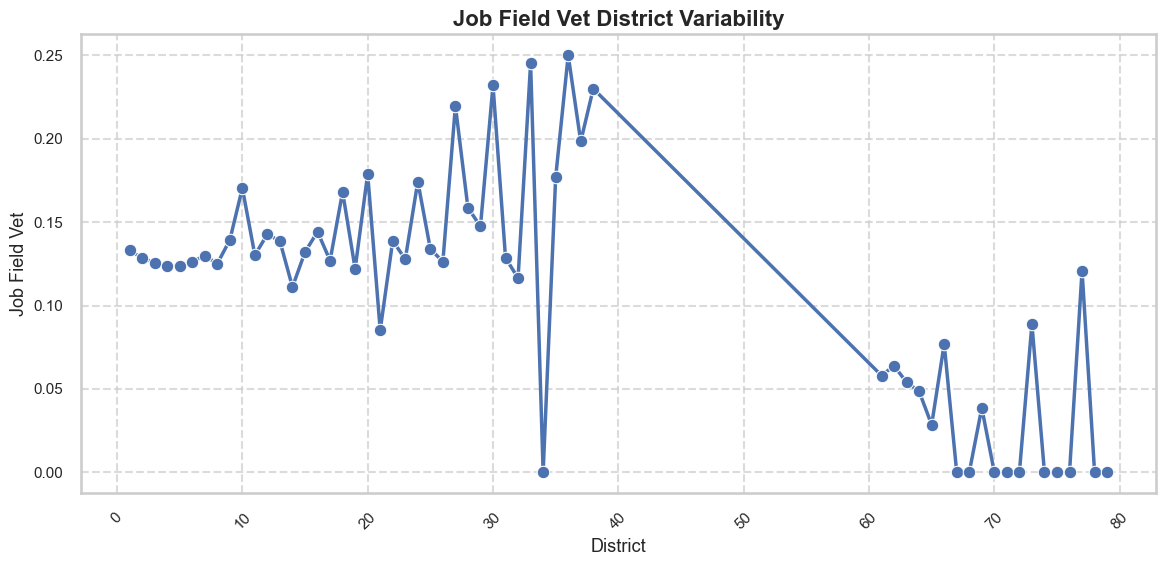

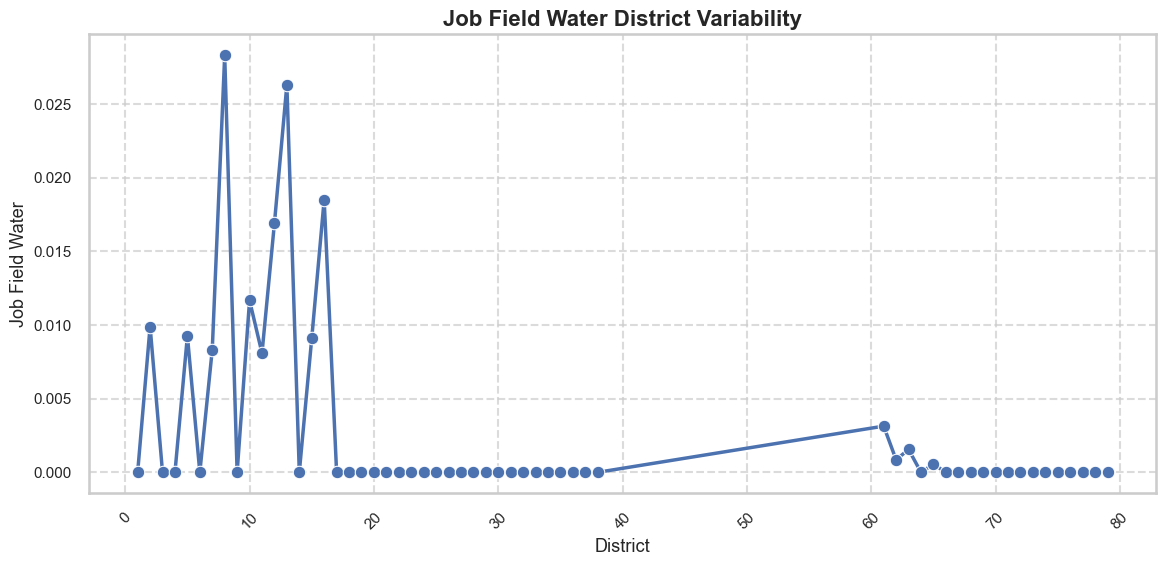

In [18]:
def plot_variability(dataframe):
    exclude_columns = ['work_time', 'year', 'district', 'voivodeship', 'institution']
    df_grouped = dataframe.groupby('district').mean(numeric_only=True)
    columns_to_plot = [col for col in df_grouped.columns if col not in exclude_columns]

    sns.set(style="whitegrid", context="talk", palette="deep")

    for column in columns_to_plot:
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=df_grouped.index, y=df_grouped[column], marker='o', linewidth=2.5)
        plt.title(f"{column.replace('_', ' ').title()} District Variability", fontsize=16, weight='bold')
        plt.xlabel("District", fontsize=13)
        plt.ylabel(column.replace('_', ' ').title(), fontsize=13)
        plt.xticks(rotation=45, fontsize=11)
        plt.yticks(fontsize=11)
        plt.grid(visible=True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

plot_variability(df_for_charts)

##### Spaghetti plots

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_spaghetti_chart(df: pd.DataFrame, time_col: str, group_col: str = None, 
                         title: str = "Spaghetti Chart", xlabel: str = "Time", 
                         ylabel: str = "Result", figsize: tuple = (12, 7), 
                         alpha: float = 0.7, linewidth: float = 1.0, 
                         cmap_name: str = 'viridis') -> None:
    """
    Plots a spaghetti chart from a pandas DataFrame, with each line having a different color.
    The variable to be plotted on the y-axis is always assumed to be named 'result'.

    Args:
        df (pd.DataFrame): The input DataFrame.
        time_col (str): The name of the column representing the time axis. This column
                        should be in a datetime format or easily convertible.
        group_col (str, optional): The name of the column that defines individual lines/series.
                                   If None, the function will attempt to plot based on
                                   'result' column directly, which might not be a typical
                                   spaghetti plot unless 'result' itself contains multiple
                                   series (e.g., if 'result' is a list of column names).
                                   Defaults to None.
        title (str, optional): The title of the chart. Defaults to "Spaghetti Chart".
        xlabel (str, optional): The label for the x-axis. Defaults to "Time".
        ylabel (str, optional): The label for the y-axis. Defaults to "Result".
        figsize (tuple, optional): The size of the figure (width, height) in inches.
                                   Defaults to (12, 7).
        alpha (float, optional): The transparency of the lines (0.0 to 1.0).
                                 Defaults to 0.7.
        linewidth (float, optional): The width of the lines. Defaults to 1.0.
        cmap_name (str, optional): The name of the matplotlib colormap to use for colors.
                                   Examples: 'viridis', 'plasma', 'cividis', 'magma', 'inferno',
                                   'Set1', 'Dark2', 'Paired'. Defaults to 'viridis'.
    
    Raises:
        ValueError: If 'time_col' or 'result' columns are not found in the DataFrame.
        TypeError: If 'time_col' cannot be converted to datetime.
    """

    # The result column name is fixed to 'result'
    result_col = 'result'

    # Validate column names
    required_cols = [time_col, result_col]
    if group_col:
        required_cols.append(group_col)
    
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    # Ensure time_col is datetime
    try:
        df[time_col] = pd.to_datetime(df[time_col])
    except Exception as e:
        raise TypeError(f"Could not convert '{time_col}' to datetime. Error: {e}")

    # Sort by time for correct plotting
    df = df.sort_values(by=time_col)

    plt.figure(figsize=figsize)
    ax = plt.gca() # Get current axes

    if group_col:
        unique_groups = df[group_col].unique()
        num_groups = len(unique_groups)

        # Get a colormap
        colors = cm.get_cmap(cmap_name, num_groups)

        for i, group in enumerate(unique_groups):
            group_df = df[df[group_col] == group]
            ax.plot(group_df[time_col], group_df[result_col], 
                    color=colors(i), 
                    label=str(group), 
                    alpha=alpha, 
                    linewidth=linewidth)
        plt.legend(title=group_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        # If no group_col, plot the 'result' column directly.
        # This will result in a single line if 'result' is a single column,
        # or multiple lines if 'result' somehow refers to multiple series.
        print("Warning: No 'group_col' specified. Plotting the 'result' column directly.")
        print("If 'result' is intended to represent multiple series, ensure it's structured accordingly.")
        
        # Plot the single 'result' column with a default color
        ax.plot(df[time_col], df[result_col], color='blue', alpha=alpha, linewidth=linewidth)


    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

if __name__ == '__main__':
    # --- Example Usage ---

    # 1. Sample Data (assuming 'id' as the group_col and 'result' as the value)
    np.random.seed(42)
    dates = pd.to_datetime(pd.date_range(start='2023-01-01', periods=100, freq='D'))
    data = []
    num_individuals = 15 # Number of "spaghetti" lines

    for i in range(num_individuals):
        # Create a unique trend for each individual
        initial_value = np.random.uniform(50, 100)
        trend = np.cumsum(np.random.normal(0, 0.5, len(dates)))
        noise = np.random.normal(0, 2, len(dates))
        results = initial_value + trend + noise
        
        for j, date in enumerate(dates):
            # Column name is now 'result'
            data.append({'Date': date, 'ID': f'Individual_{i+1}', 'result': results[j]}) 

    df_spaghetti = pd.DataFrame(data)

    print("Sample DataFrame head:")
    print(df_spaghetti.head())
    print("\nSample DataFrame info:")
    df_spaghetti.info()

    # Plotting the spaghetti chart
    plot_spaghetti_chart(df_spaghetti, 
                         time_col='Date', 
                         group_col='ID', # 'result' is implicitly used
                         title='Individual Performance Over Time',
                         xlabel='Date',
                         ylabel='Performance Score',
                         figsize=(14, 8),
                         alpha=0.6,
                         linewidth=1.2,
                         cmap_name='tab20') # tab20 has 20 distinct colors

    # 2. Another example with fewer groups and a different colormap
    data_small = []
    num_small_groups = 5
    dates_small = pd.to_datetime(pd.date_range(start='2024-01-01', periods=50, freq='W'))

    for i in range(num_small_groups):
        initial_value = np.random.uniform(10, 30)
        trend = np.cumsum(np.random.normal(0, 0.2, len(dates_small)))
        noise = np.random.normal(0, 1, len(dates_small))
        results = initial_value + trend + noise
        
        for j, date in enumerate(dates_small):
            data_small.append({'Timestamp': date, 'Category': chr(65 + i), 'result': results[j]})
            
    df_small = pd.DataFrame(data_small)

    print("\nSmall Sample DataFrame head:")
    print(df_small.head())

    plot_spaghetti_chart(df_small,
                         time_col='Timestamp',
                         group_col='Category',
                         title='Category Trends Over Weeks',
                         xlabel='Week',
                         ylabel='Measurement',
                         figsize=(10, 6),
                         alpha=0.8,
                         linewidth=1.5,
                         cmap_name='Accent')

    # 3. Example with no group_col (less typical spaghetti plot, shows a single 'result' line)
    df_no_group = pd.DataFrame({
        'Date': pd.to_datetime(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05']),
        'result': [10, 12, 15, 11, 13] # Only 'result' column for plotting
    })
    print("\nDataFrame for no group_col example:")
    print(df_no_group)
    
    plot_spaghetti_chart(df_no_group,
                         time_col='Date',
                         title='Single Series Plot (No Group)',
                         figsize=(8, 5))

## Feature importance

##### Generalized Linear Mixed Models

In [ ]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM



##### Conclusions

In [ ]:
# # As a result of the above analyses, I decided to exclude certain columns due to their low variability or low correlation.
# 
# cols_to_exclude = [
#     'women_percentage',
#     'bdl_feminization_coefficient',
#     'work_time',
#     'job_field_documents',
#     'job_field_environment',
#     'bdl_age_median',
#     'job_field_water',
#     'bdl_avg_house_pricing',
#     'vacancies',
#     'fluctuation',
#     'salary_for_position'
# ]
# 
# df_institution_level = df_institution_level.drop(columns=cols_to_exclude, axis=1)